In [1]:
import torch as tr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.seq2seq.model.unet import seq2seq

In [2]:
WEIGHTS_PATH = 'results/model_4_8/model_4_8_skip0_Optim_lr_avg_traspose/nc2-lr-5e-2-iter1/weights.pmt'

In [6]:
model = seq2seq()
model.load_state_dict(tr.load(WEIGHTS_PATH))
model.eval()

No weights provided, using random initialization


/tmp/ipykernel_1646224/2589489107.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(tr.load(WEIGHTS_PATH))


Seq2Seq(
  (inc): N_Conv(
    (N_Conv): Sequential(
      (0): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down): ModuleList(
    (0): DownBlock(
      (down): Sequential(
        (0): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
        (1): N_Conv(
          (N_Conv): Sequential(
            (0): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
            (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [17]:
model.parameters
for name, param in model.named_parameters():
    print(f"{name}: {param.data.shape}")

inc.N_Conv.0.weight: torch.Size([4, 4, 3])
inc.N_Conv.0.bias: torch.Size([4])
inc.N_Conv.1.weight: torch.Size([4])
inc.N_Conv.1.bias: torch.Size([4])
inc.N_Conv.3.weight: torch.Size([4, 4, 3])
inc.N_Conv.3.bias: torch.Size([4])
inc.N_Conv.4.weight: torch.Size([4])
inc.N_Conv.4.bias: torch.Size([4])
down.0.down.1.N_Conv.0.weight: torch.Size([8, 4, 3])
down.0.down.1.N_Conv.0.bias: torch.Size([8])
down.0.down.1.N_Conv.1.weight: torch.Size([8])
down.0.down.1.N_Conv.1.bias: torch.Size([8])
down.0.down.1.N_Conv.3.weight: torch.Size([8, 8, 3])
down.0.down.1.N_Conv.3.bias: torch.Size([8])
down.0.down.1.N_Conv.4.weight: torch.Size([8])
down.0.down.1.N_Conv.4.bias: torch.Size([8])
up.0.up.weight: torch.Size([8, 4, 3])
up.0.up.bias: torch.Size([4])
up.0.conv.N_Conv.0.weight: torch.Size([4, 4, 3])
up.0.conv.N_Conv.0.bias: torch.Size([4])
up.0.conv.N_Conv.1.weight: torch.Size([4])
up.0.conv.N_Conv.1.bias: torch.Size([4])
up.0.conv.N_Conv.3.weight: torch.Size([4, 4, 3])
up.0.conv.N_Conv.3.bias: torc

In [18]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_conv1d_kernels(layer, name=""):
    weight = layer.weight.data.cpu().numpy()  # [out_channels, in_channels, kernel_size]
    out_ch, in_ch, k = weight.shape

    for i in range(out_ch):
        fig, ax = plt.subplots(figsize=(in_ch, 1.5))
        sns.heatmap(
            weight[i],  # shape: [in_channels, kernel_size]
            cmap="coolwarm",
            cbar=True,
            xticklabels=np.arange(k),
            yticklabels=[f"Canal {j}" for j in range(in_ch)],
            ax=ax
        )
        ax.set_title(f"Kernel {i} – {name}")
        ax.set_xlabel("Posición en kernel")
        ax.set_ylabel("Canal de entrada")
        plt.tight_layout()
        plt.show()


In [ ]:
plot_conv1d_kernels(model.down[0].down[1].N_Conv[0], name="down.1[0]")


In [32]:
def plot_kernels_as_lines(layer, name=""):
    weight = layer.weight.data.cpu().numpy()  # [out_ch, in_ch, kernel_size]
    out_ch, in_ch, k = weight.shape

    for i in range(out_ch):
        plt.figure(figsize=(6, 3))
        for j in range(in_ch):
            plt.plot(weight[i, j], label=f'Canal {j}')
        plt.title(f'Filtro {i} – {name}')
        plt.xlabel('Posición del kernel')
        plt.ylabel('Peso')
        plt.axhline(0, color='gray', linewidth=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()


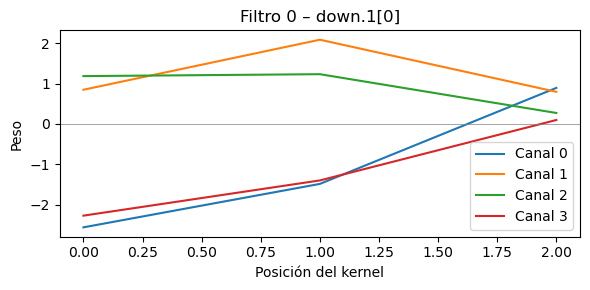

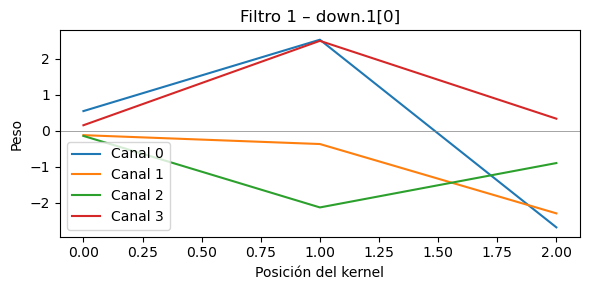

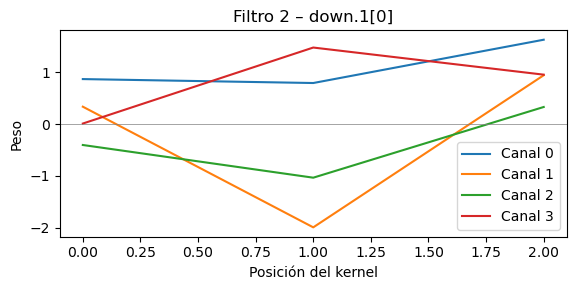

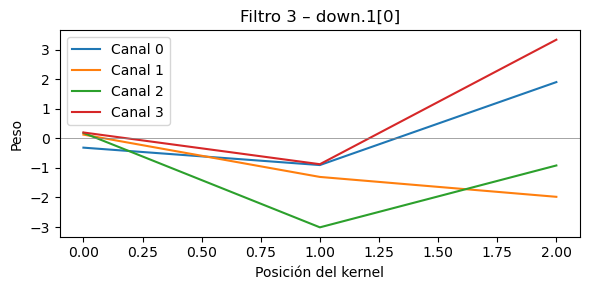

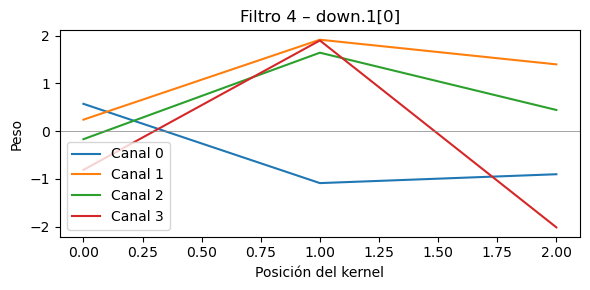

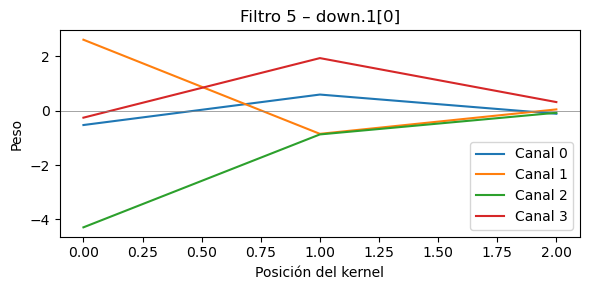

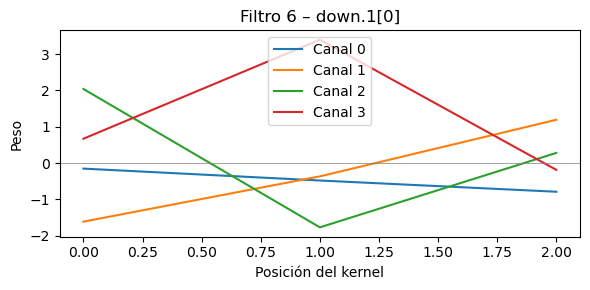

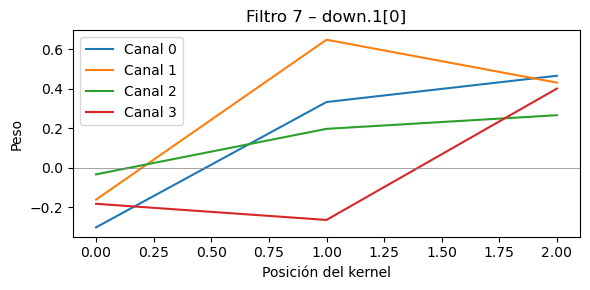

In [33]:
plot_kernels_as_lines(model.down[0].down[1].N_Conv[0], name="down.1[0]")

In [34]:
def impulse_response(layer, name=""):
    with torch.no_grad():
        in_ch = layer.weight.shape[1]
        kernel_size = layer.weight.shape[2]

        # Crea impulso: canal por canal
        impulse = torch.zeros(1, in_ch, 21)  # batch_size=1
        impulse[0, :, 10] = 1.0  # impulso en el centro

        response = layer(impulse).squeeze().cpu().numpy()  # [out_ch, L]
        out_ch = response.shape[0]

        for i in range(out_ch):
            plt.plot(response[i], label=f'Salida {i}')
        plt.title(f'Respuesta al impulso – {name}')
        plt.xlabel("Posición")
        plt.ylabel("Valor de salida")
        plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()


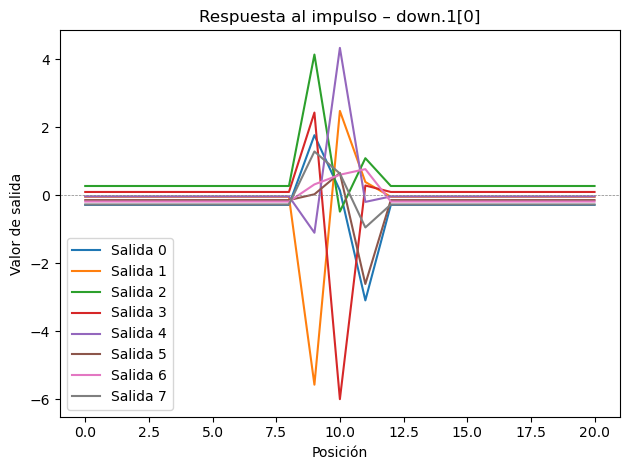

In [35]:
impulse_response(model.down[0].down[1].N_Conv[0], name="down.1[0]")

In [36]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def format_layer_name(name, layer_type):
    return f"Capa: {name} ({layer_type})"

def impulse_response(layer, in_ch):
    impulse = torch.zeros(1, in_ch, 21)
    impulse[0, :, 10] = 1.0
    with torch.no_grad():
        response = layer(impulse).squeeze().cpu().numpy()  # [out_ch, L]
    return response

def plot_full_kernel_analysis(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d):
            W = module.weight.data.cpu().numpy()  # [out_ch, in_ch, k]
            out_ch, in_ch, k = W.shape
            response = impulse_response(module, in_ch)

            for i in range(out_ch):
                fig, axs = plt.subplots(2, 2, figsize=(12, 8))
                fig.suptitle(format_layer_name(name, "Conv1d") + f" - Filtro {i}", fontsize=14)

                # 1. Heatmap del kernel
                sns.heatmap(W[i], ax=axs[0, 0], cmap="coolwarm",
                            xticklabels=np.arange(k),
                            yticklabels=[f"In {j}" for j in range(in_ch)])
                axs[0, 0].set_title("Mapa de calor del kernel")
                axs[0, 0].set_xlabel("Posición en kernel")
                axs[0, 0].set_ylabel("Canal de entrada")

                # 2. Gráfico de líneas
                for j in range(in_ch):
                    axs[0, 1].plot(W[i, j], label=f"In {j}")
                axs[0, 1].set_title("Pesos del kernel por canal")
                axs[0, 1].legend()
                axs[0, 1].set_xlabel("Posición")
                axs[0, 1].set_ylabel("Peso")

                # 3. Normas por canal
                norms = np.linalg.norm(W[i], axis=1)
                axs[1, 0].bar(np.arange(in_ch), norms)
                axs[1, 0].set_title("Norma L2 por canal de entrada")
                axs[1, 0].set_xlabel("Canal de entrada")
                axs[1, 0].set_ylabel("Norma")

                # 4. Respuesta al impulso
                axs[1, 1].plot(response[i])
                axs[1, 1].set_title("Respuesta al impulso")
                axs[1, 1].set_xlabel("Posición")
                axs[1, 1].set_ylabel("Salida")

                plt.tight_layout(rect=[0, 0, 1, 0.95])
                plt.show()


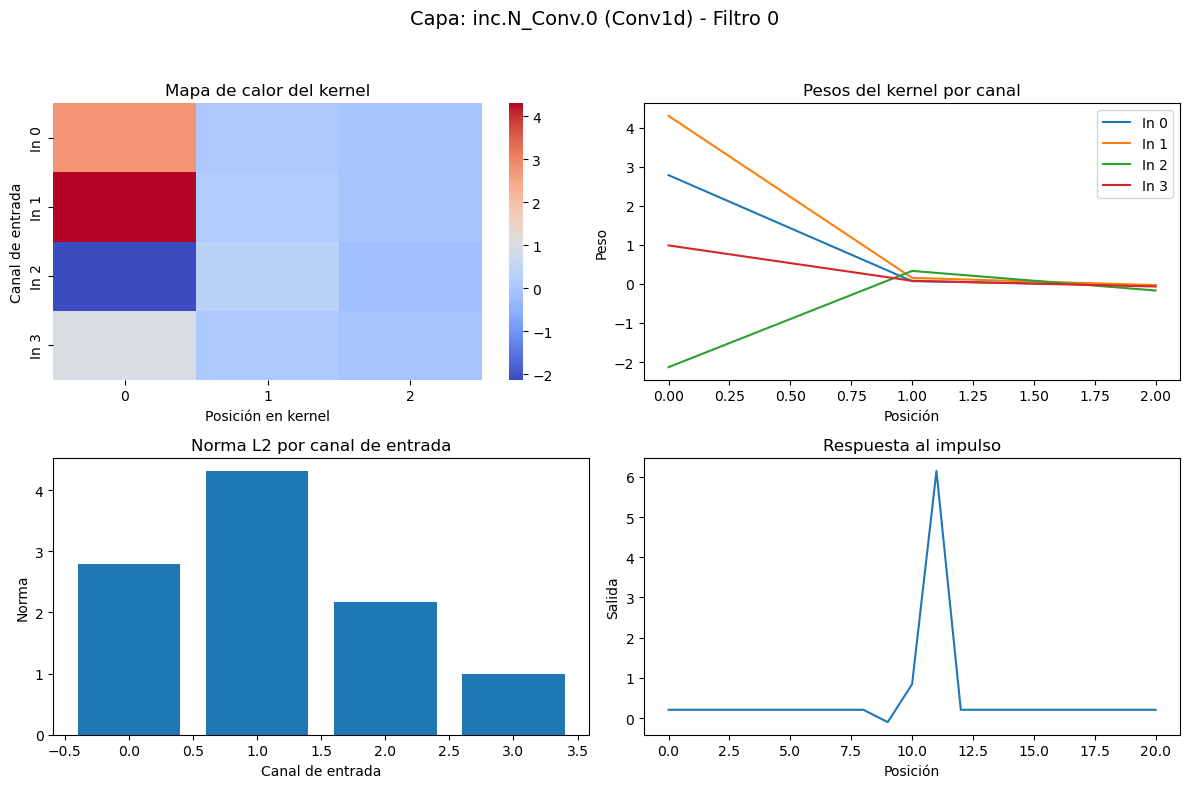

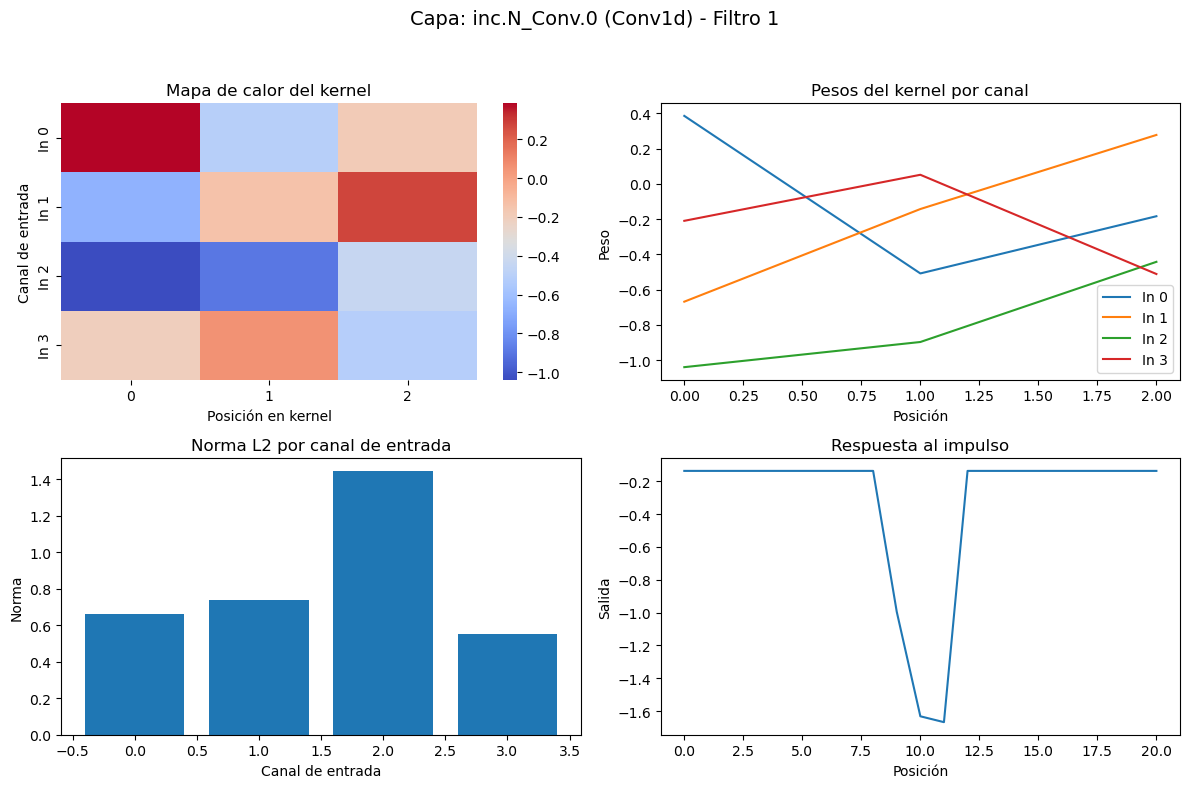

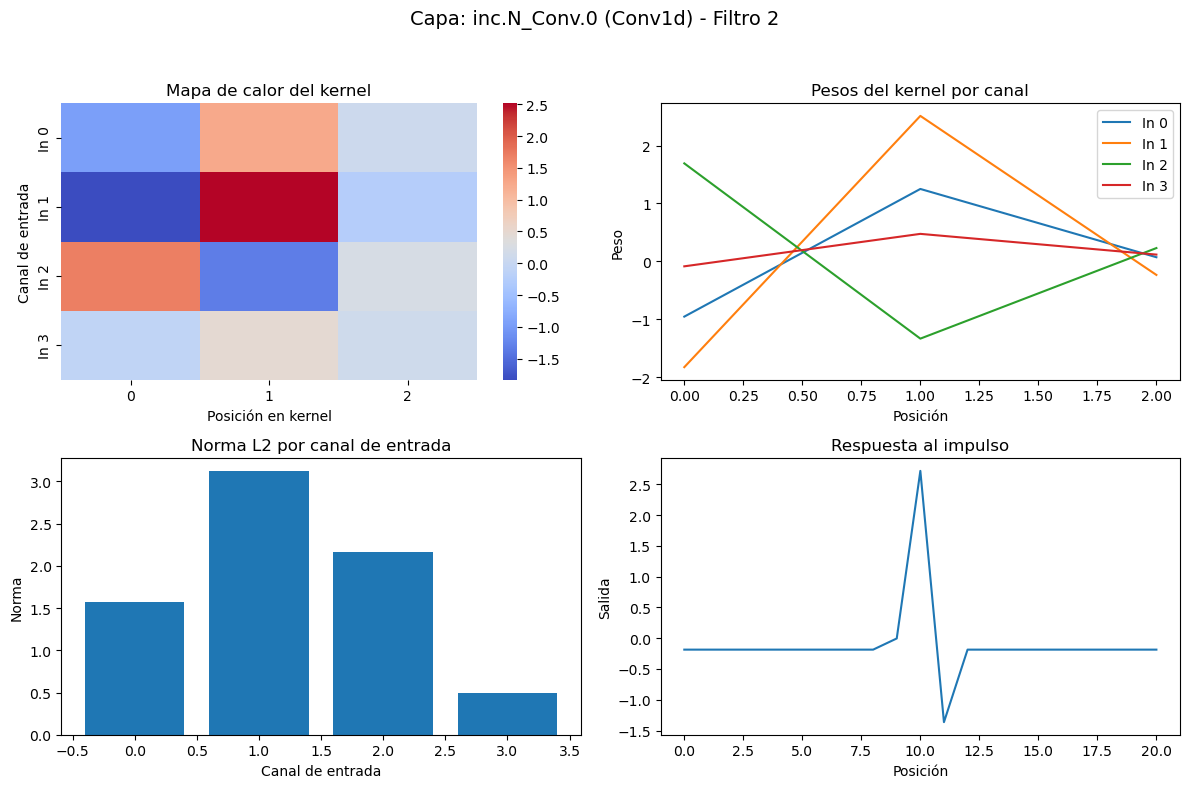

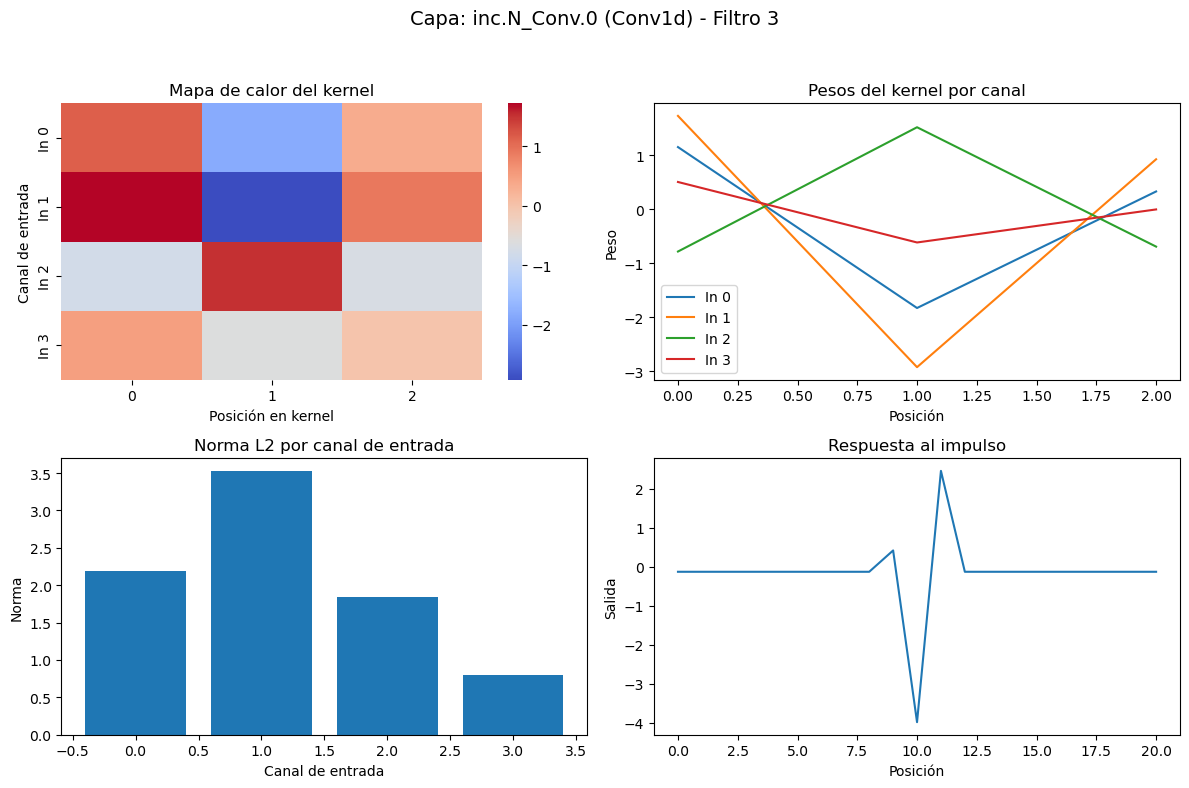

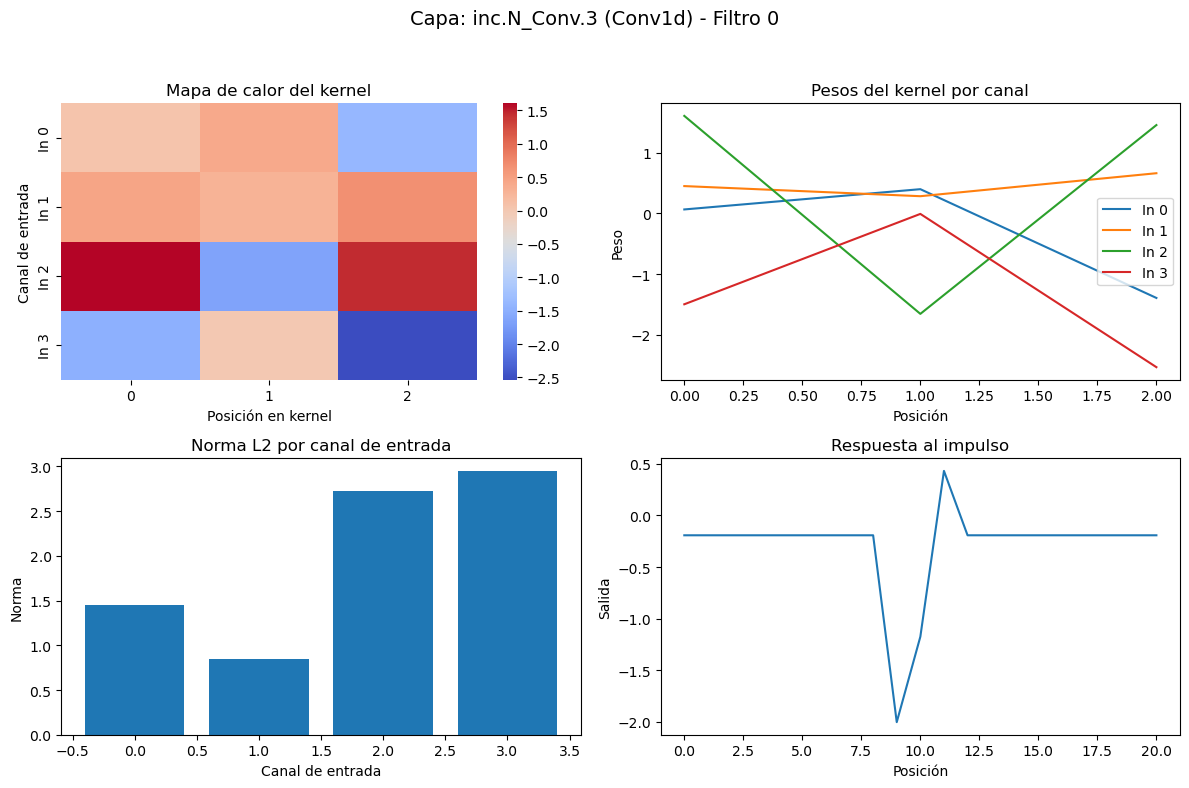

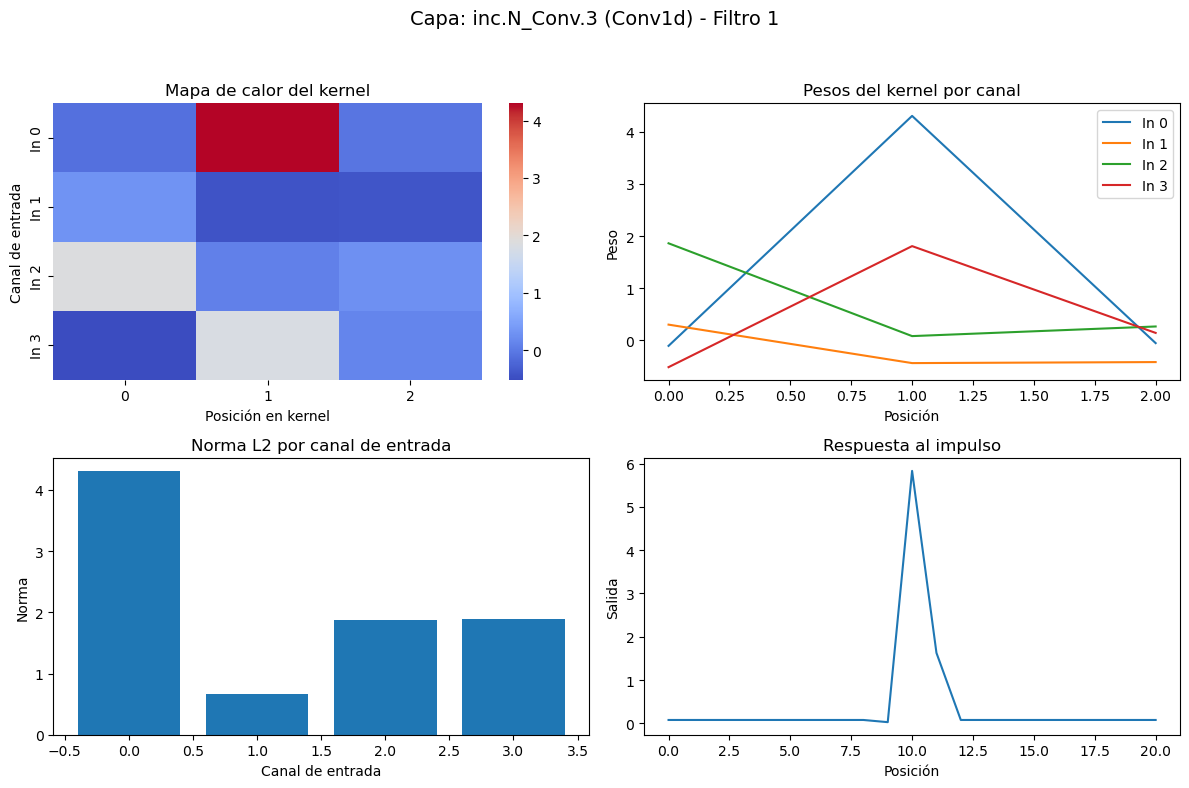

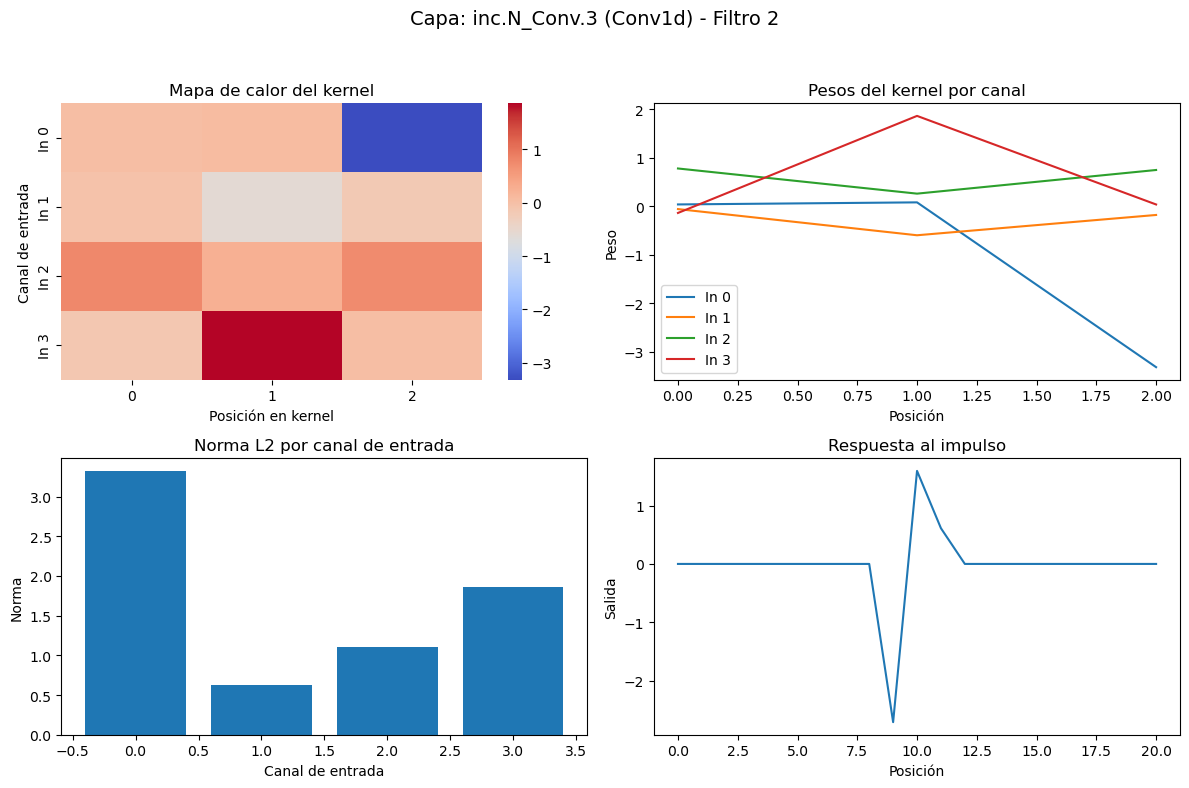

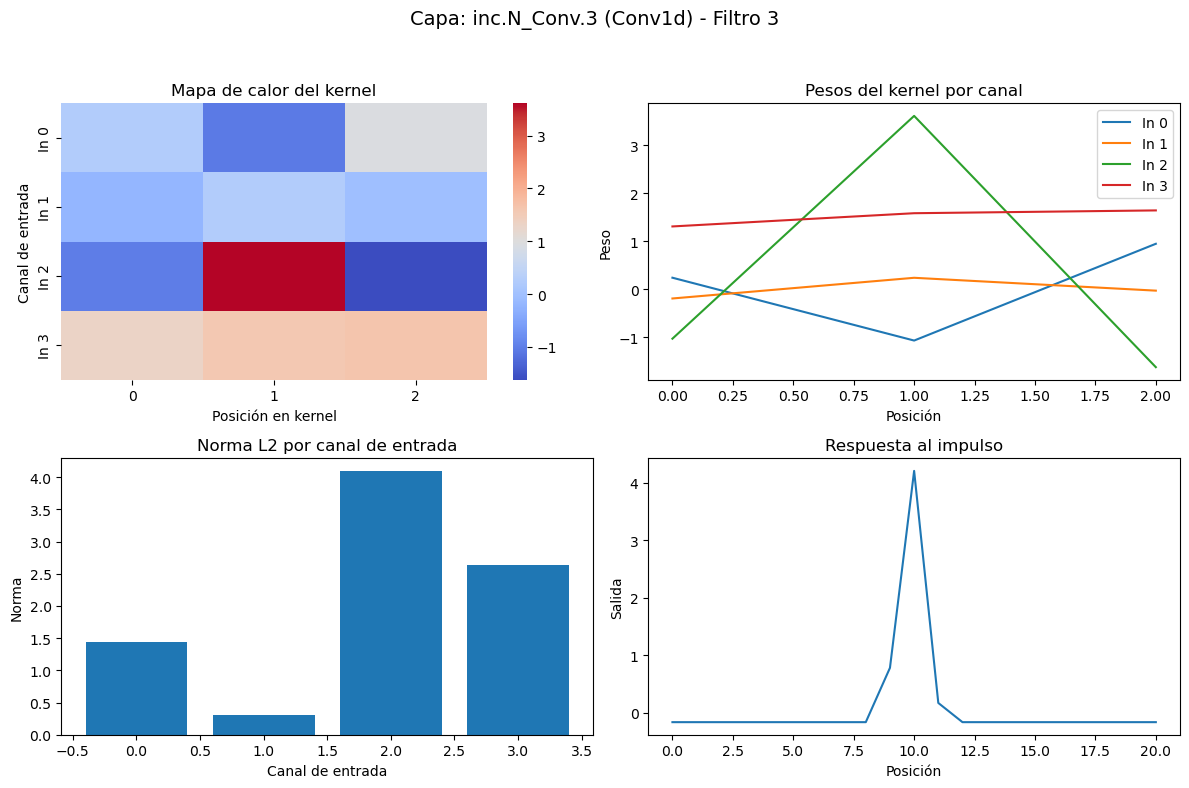

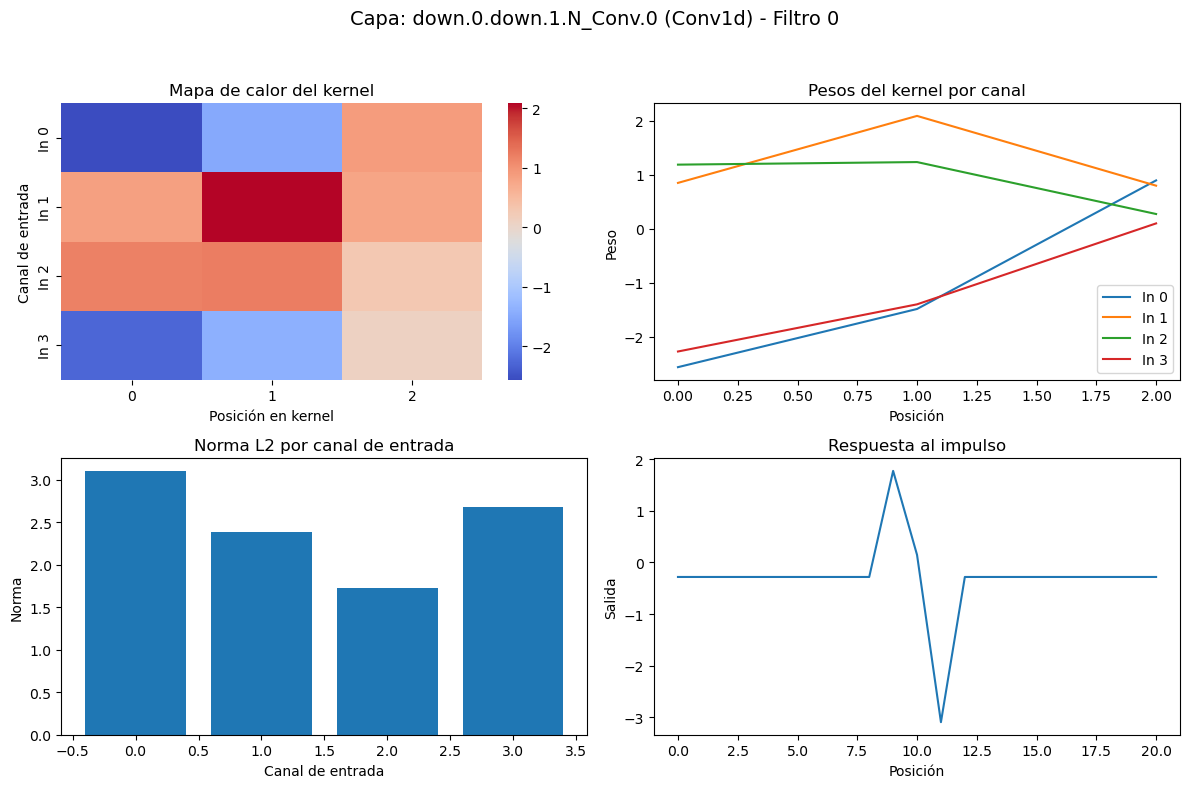

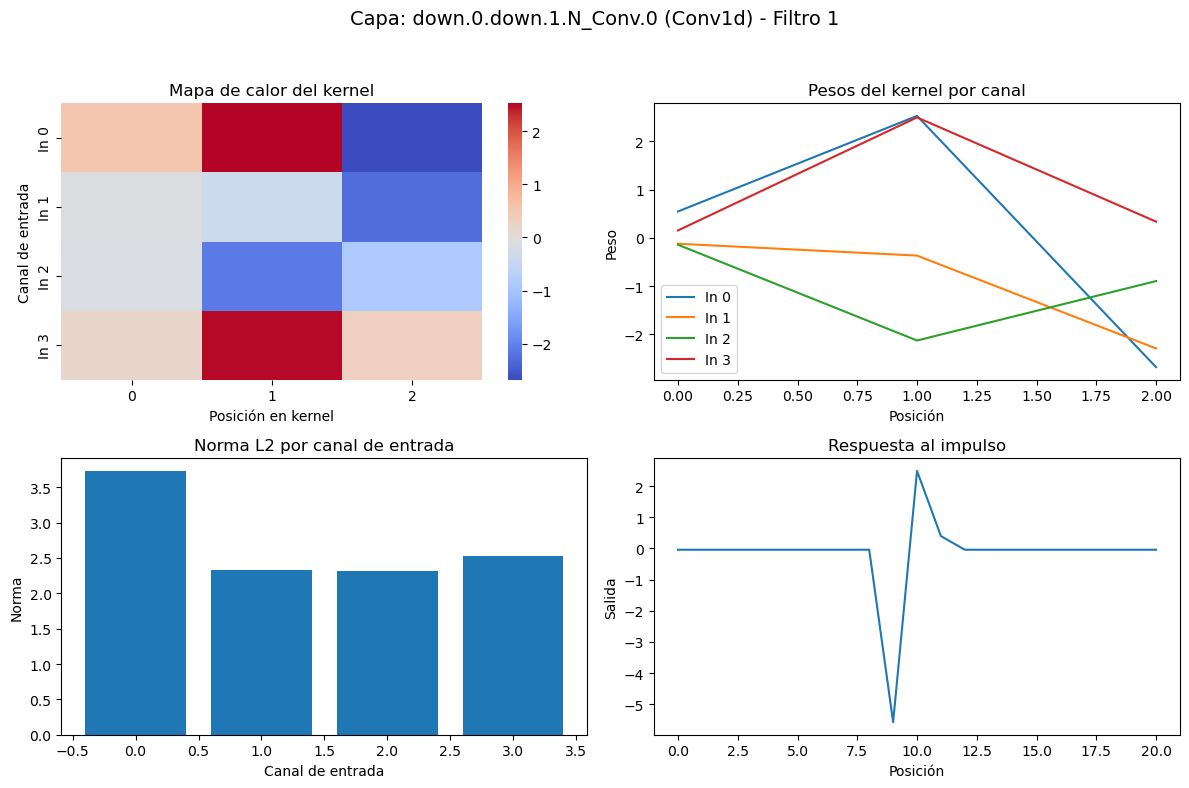

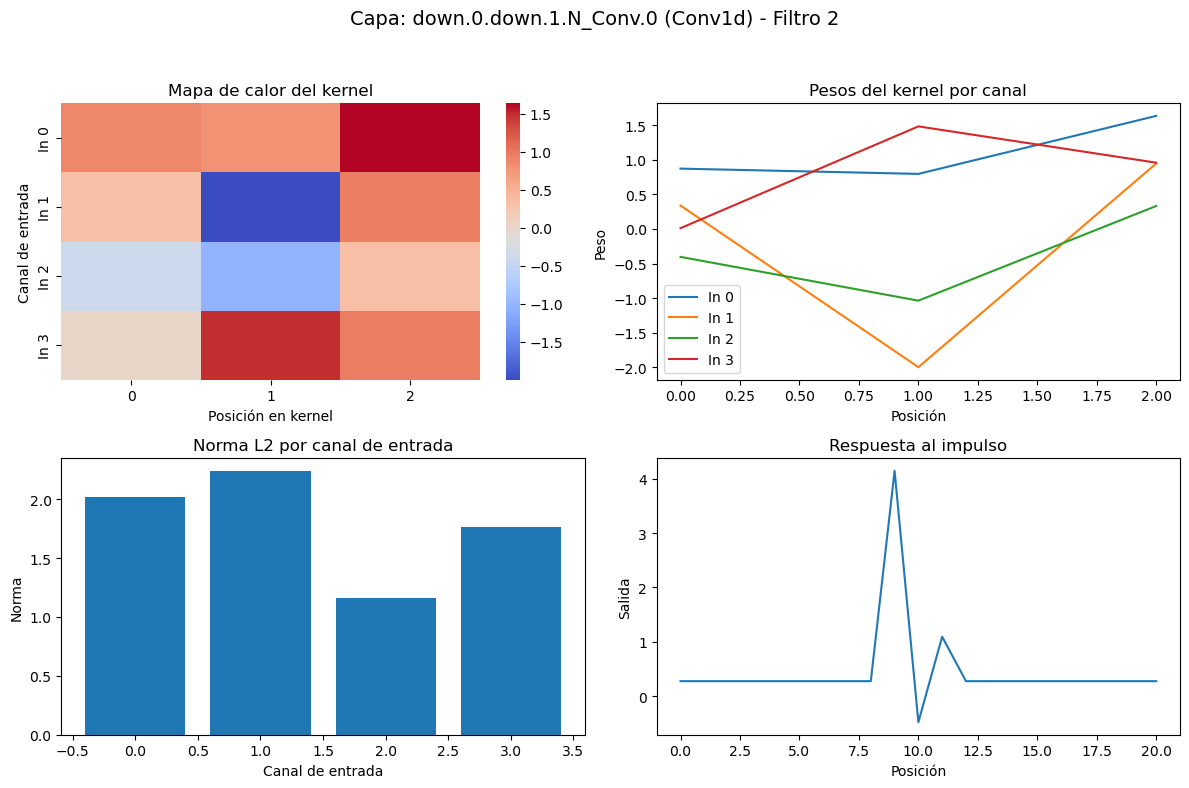

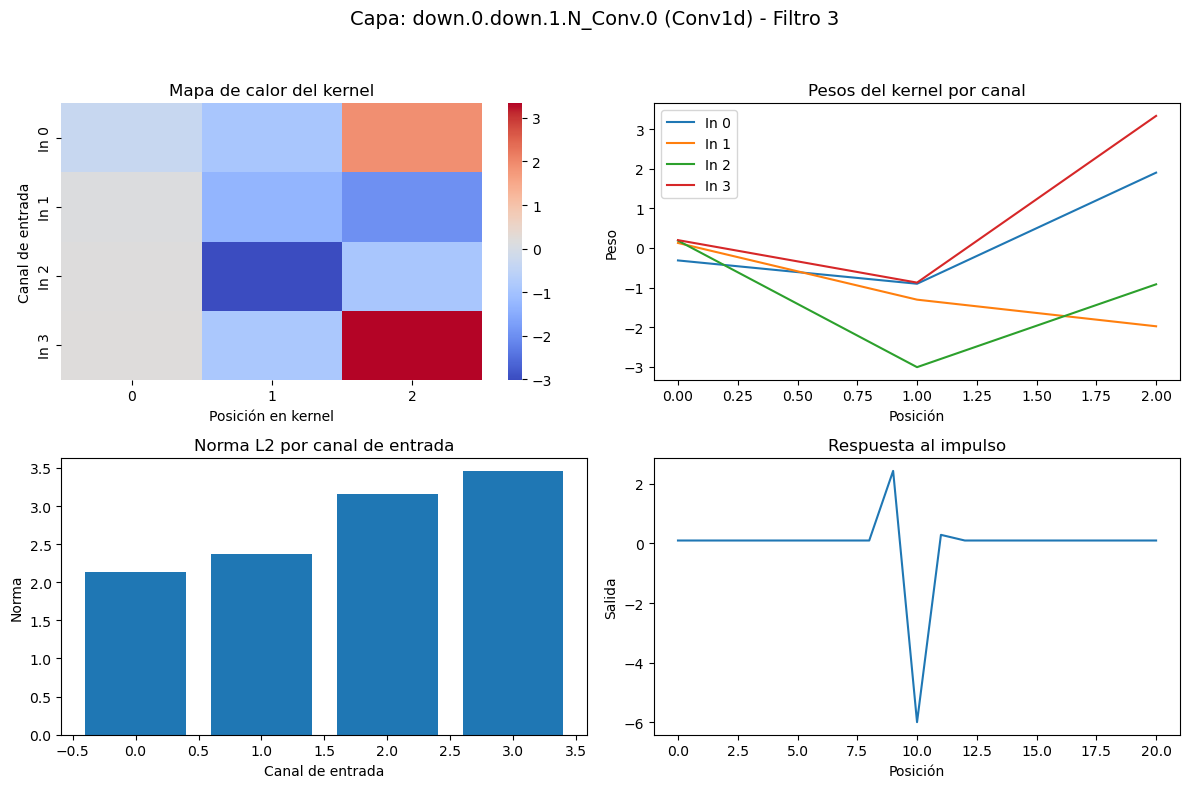

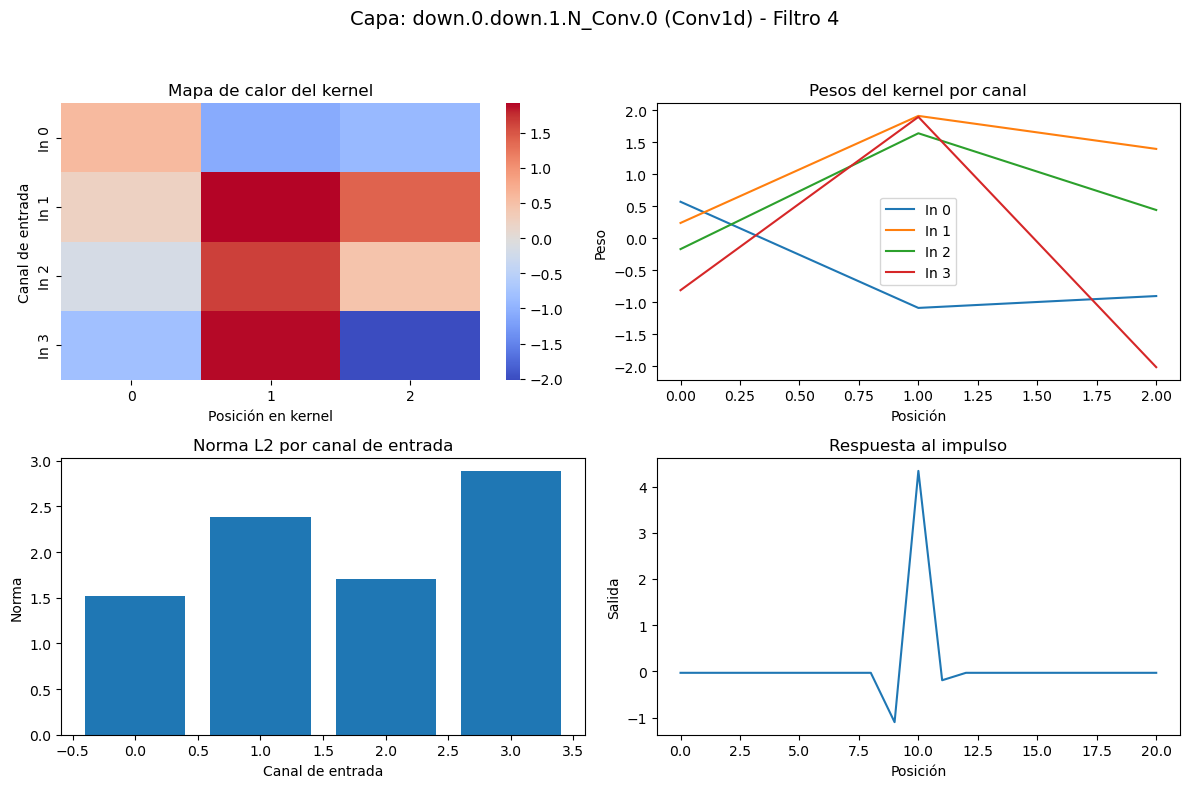

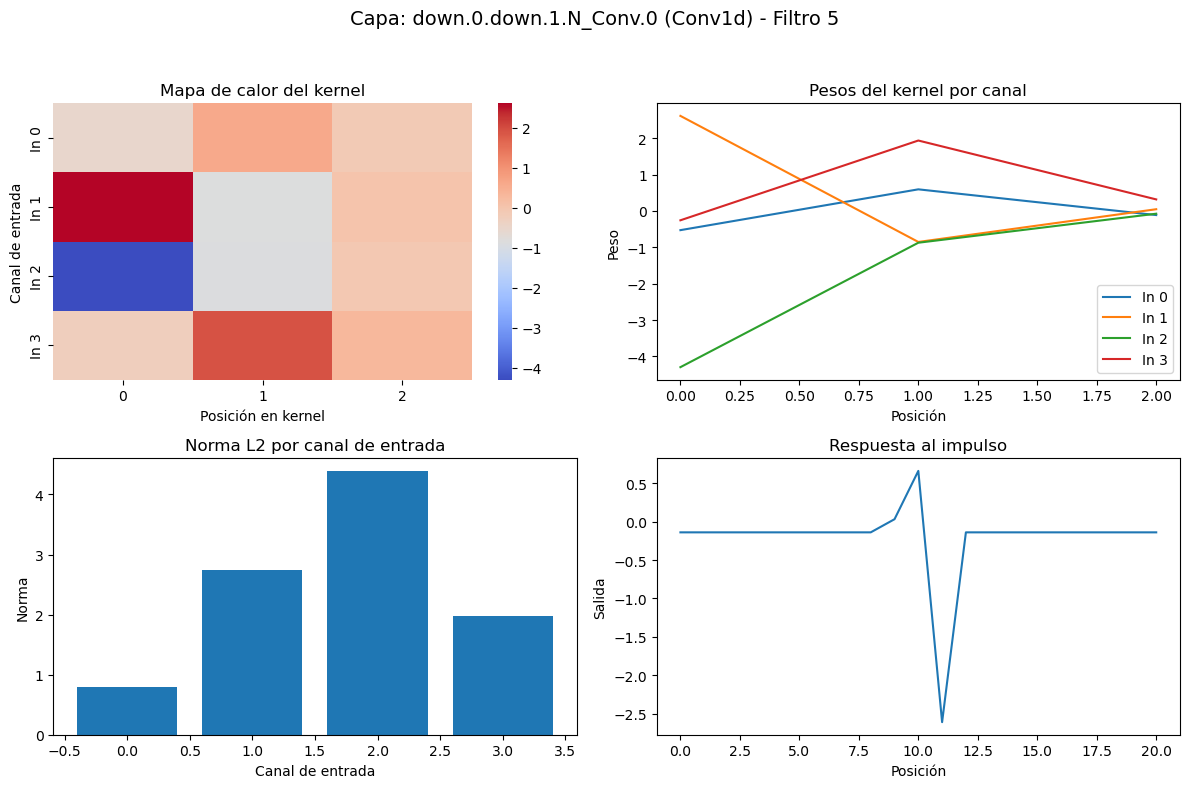

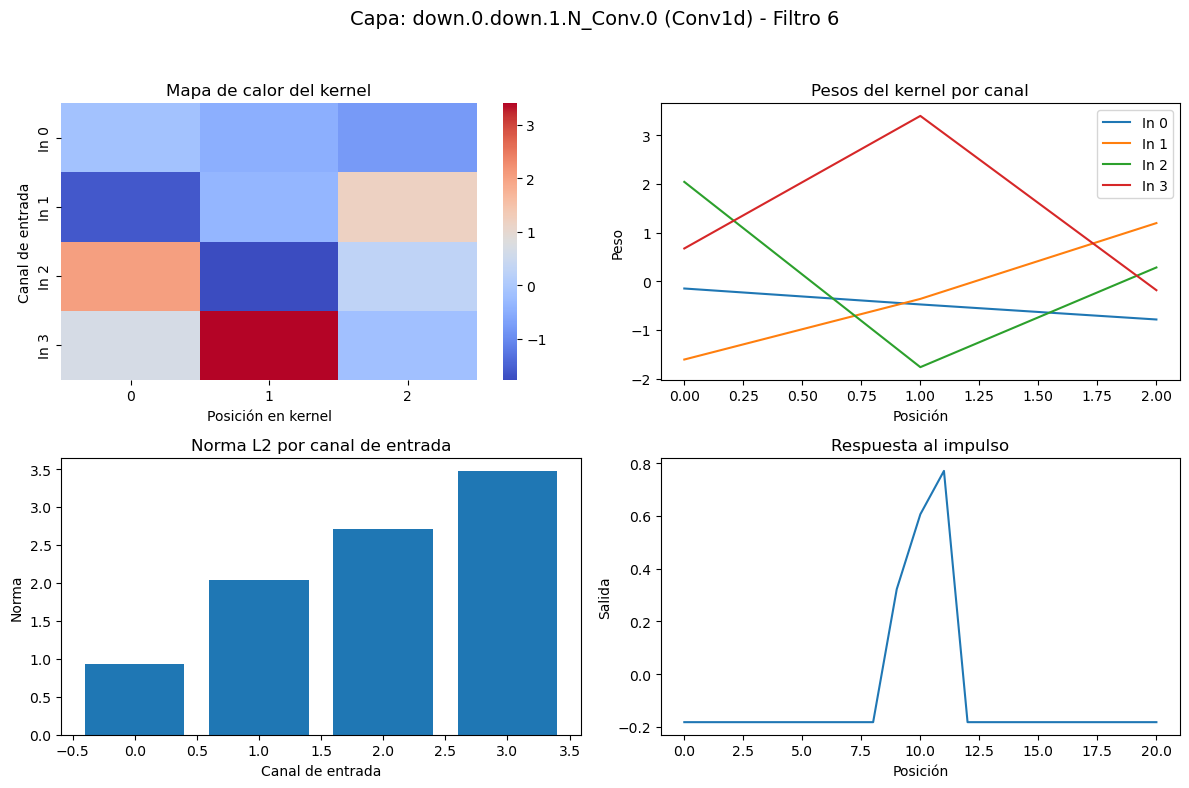

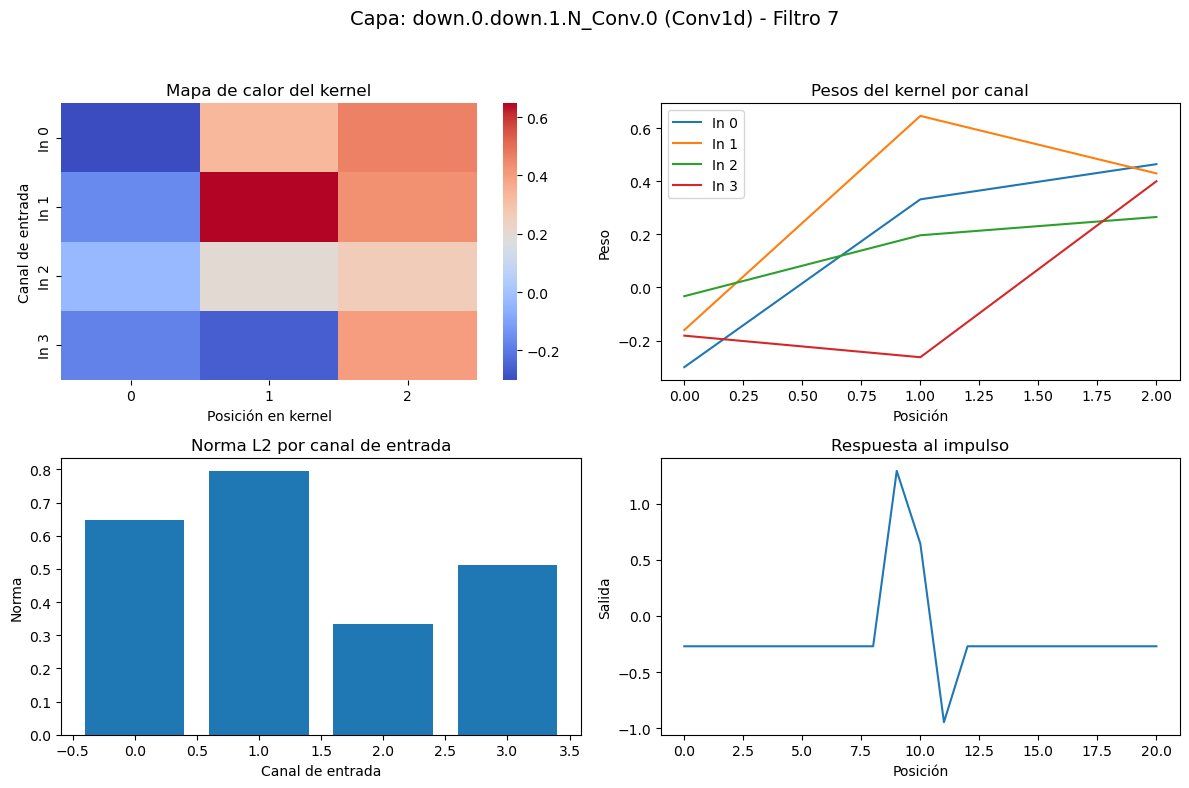

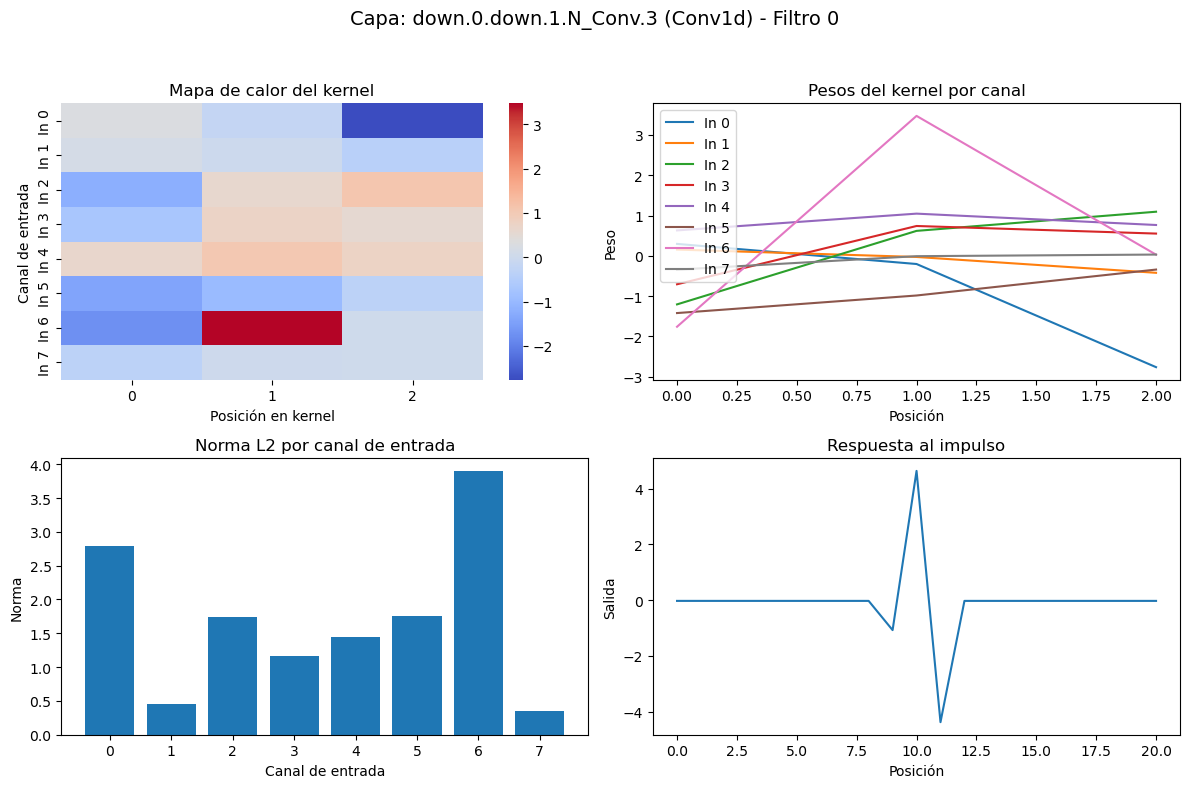

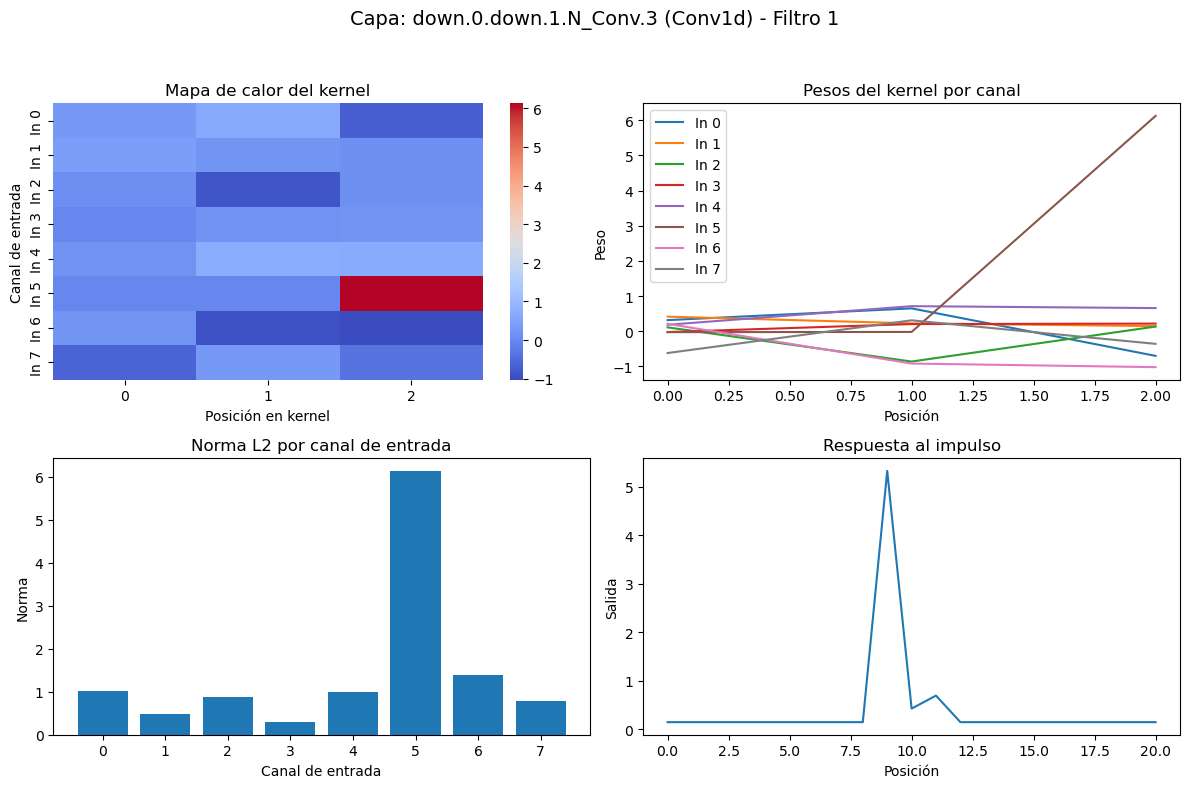

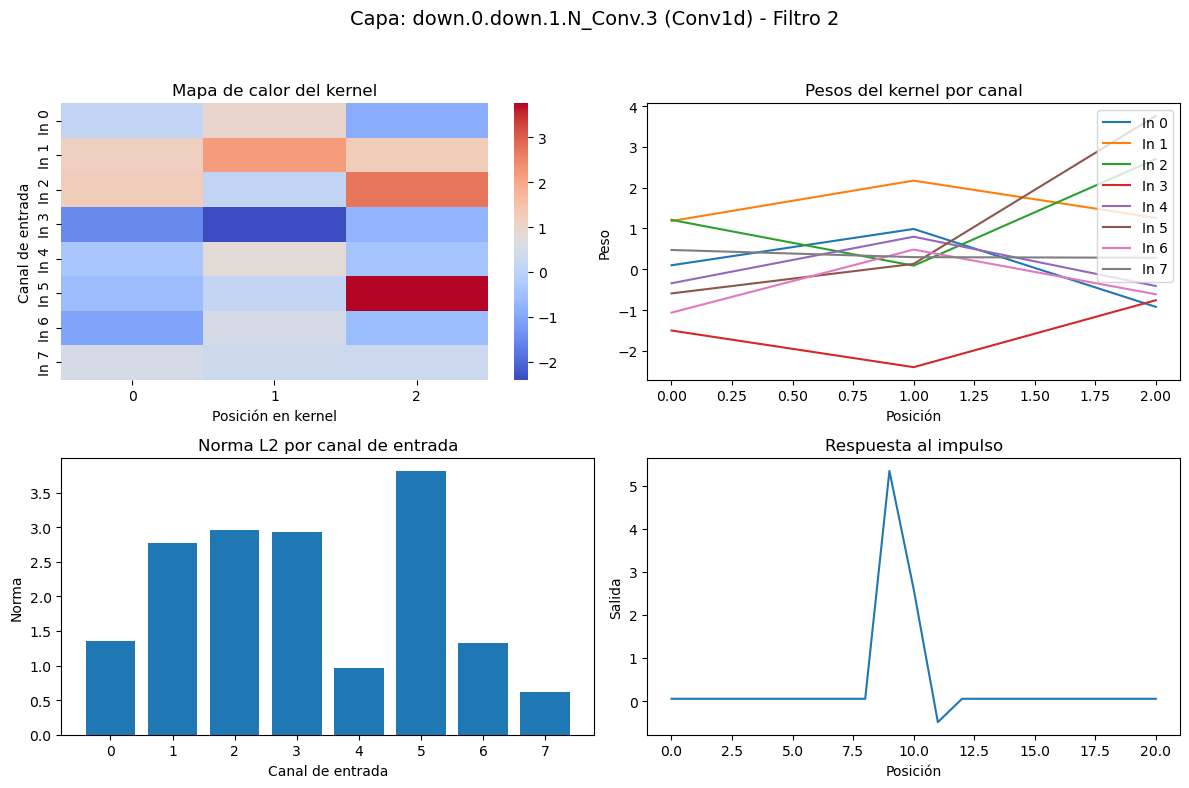

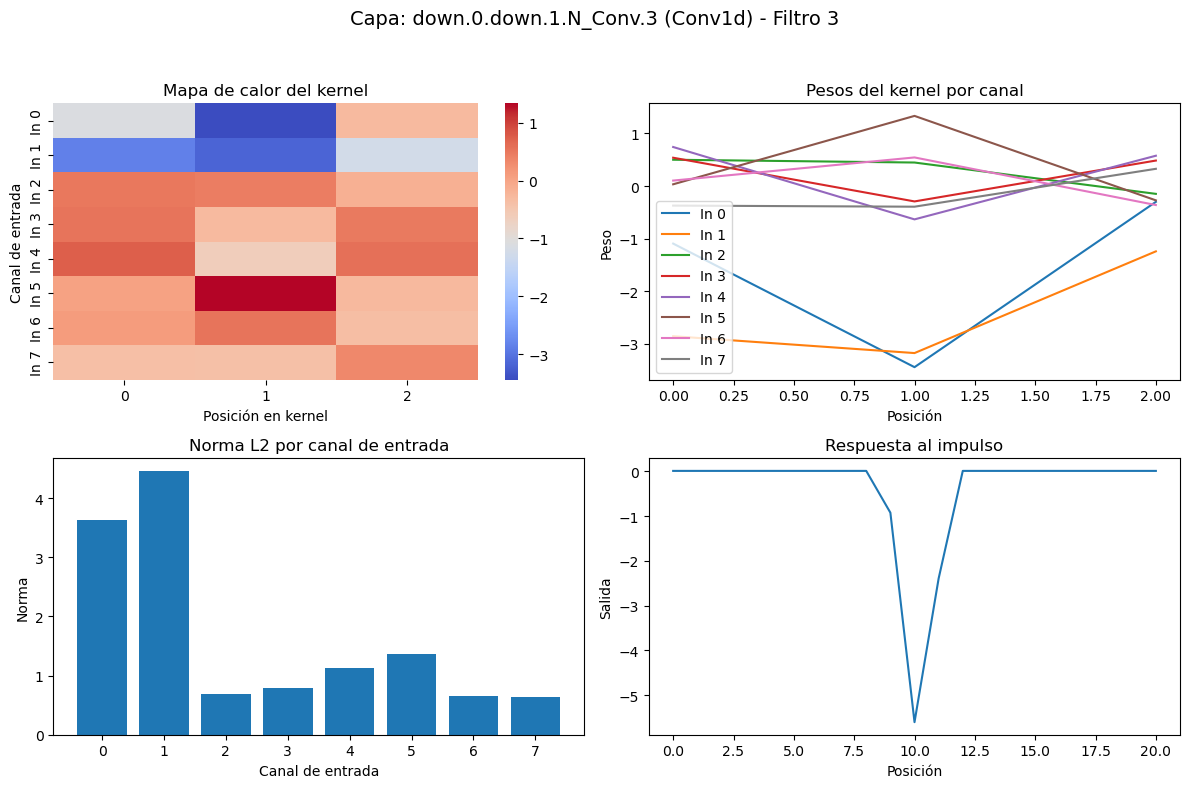

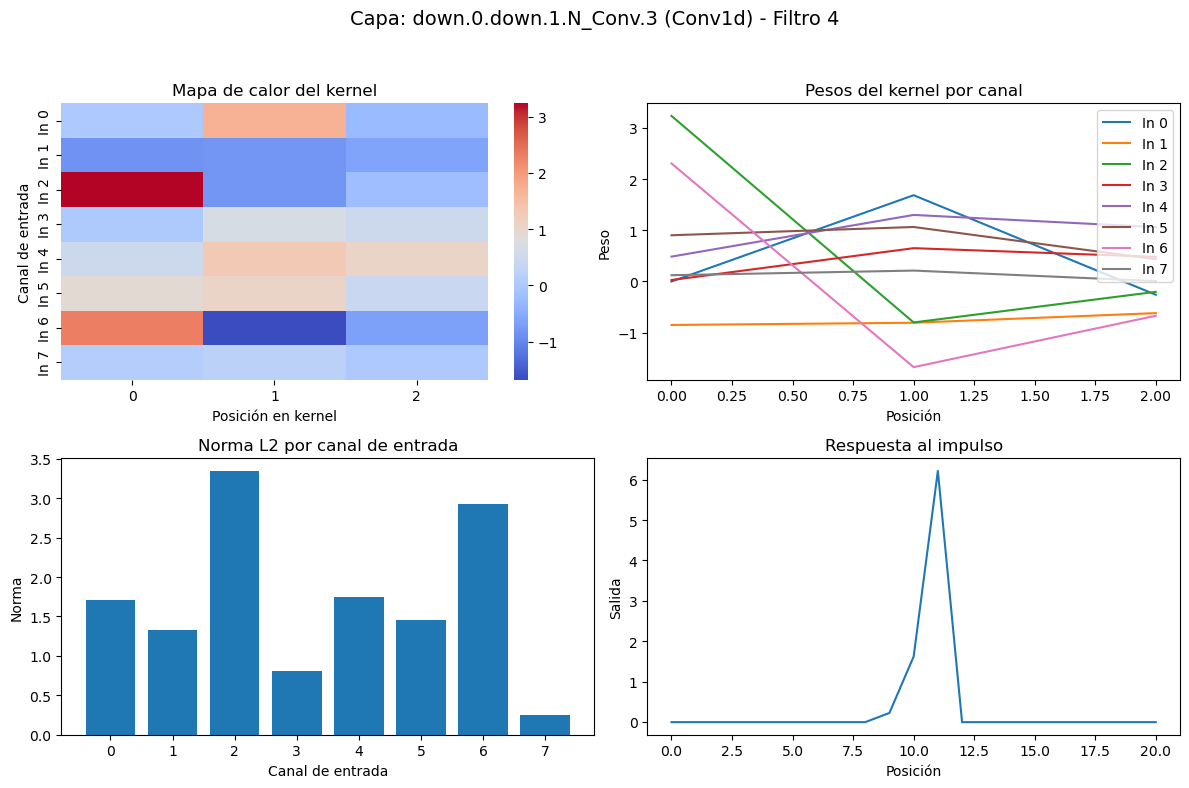

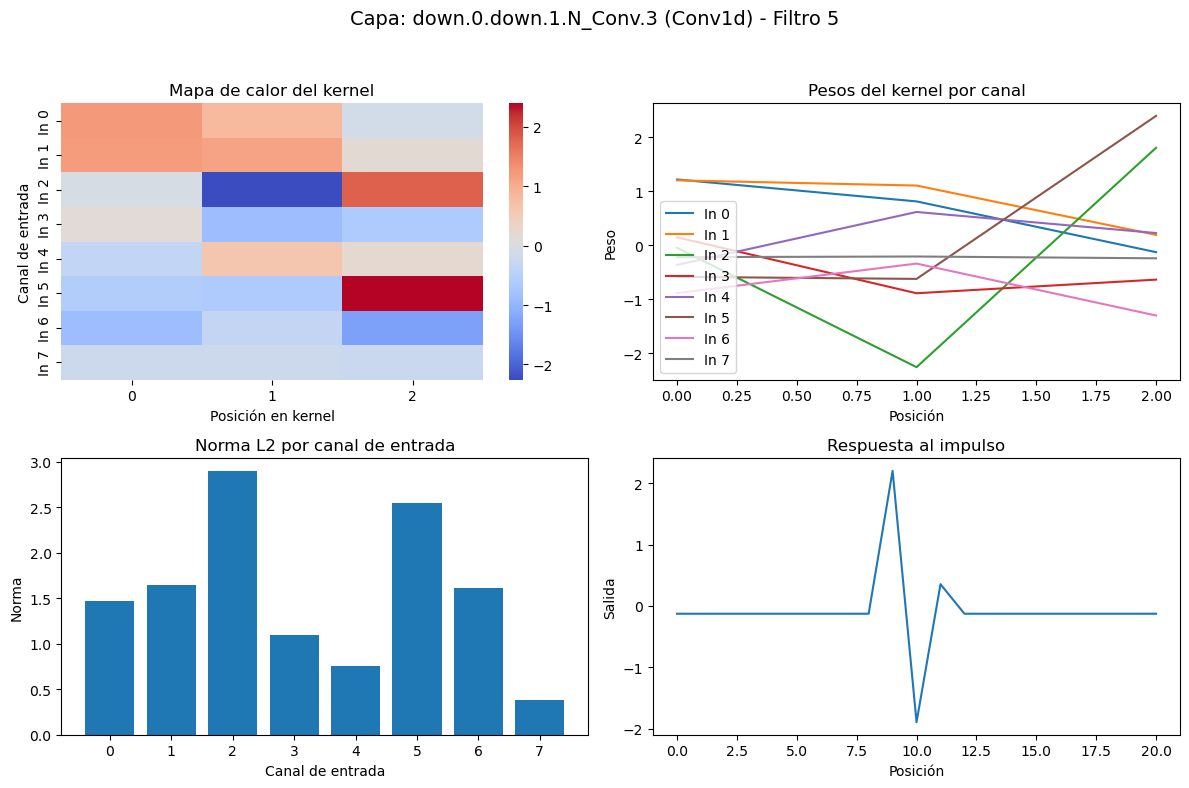

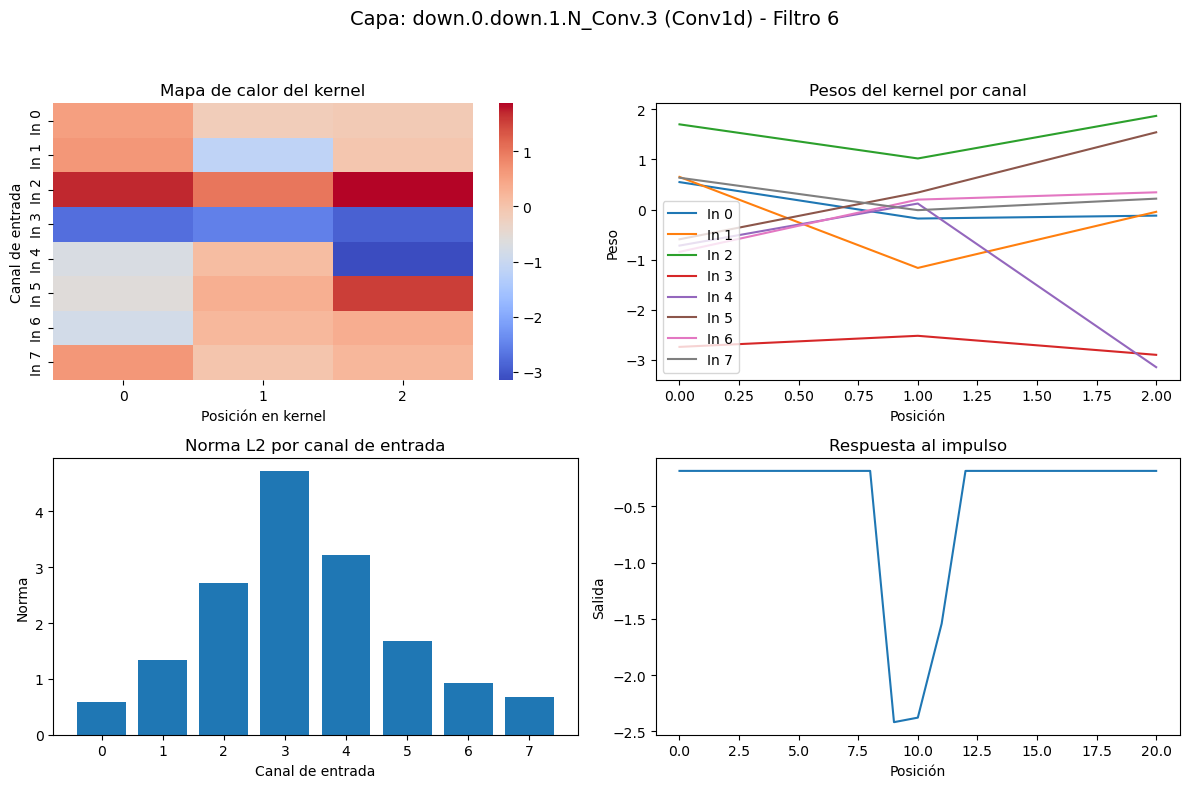

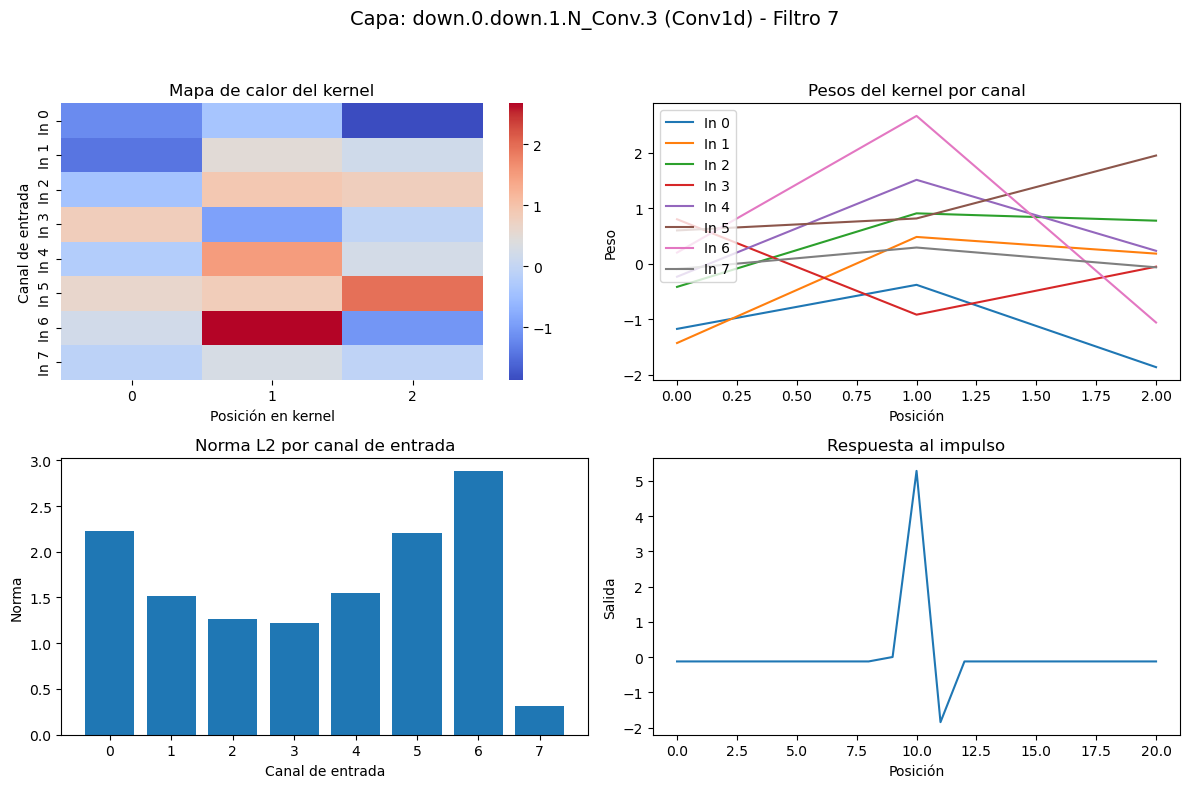

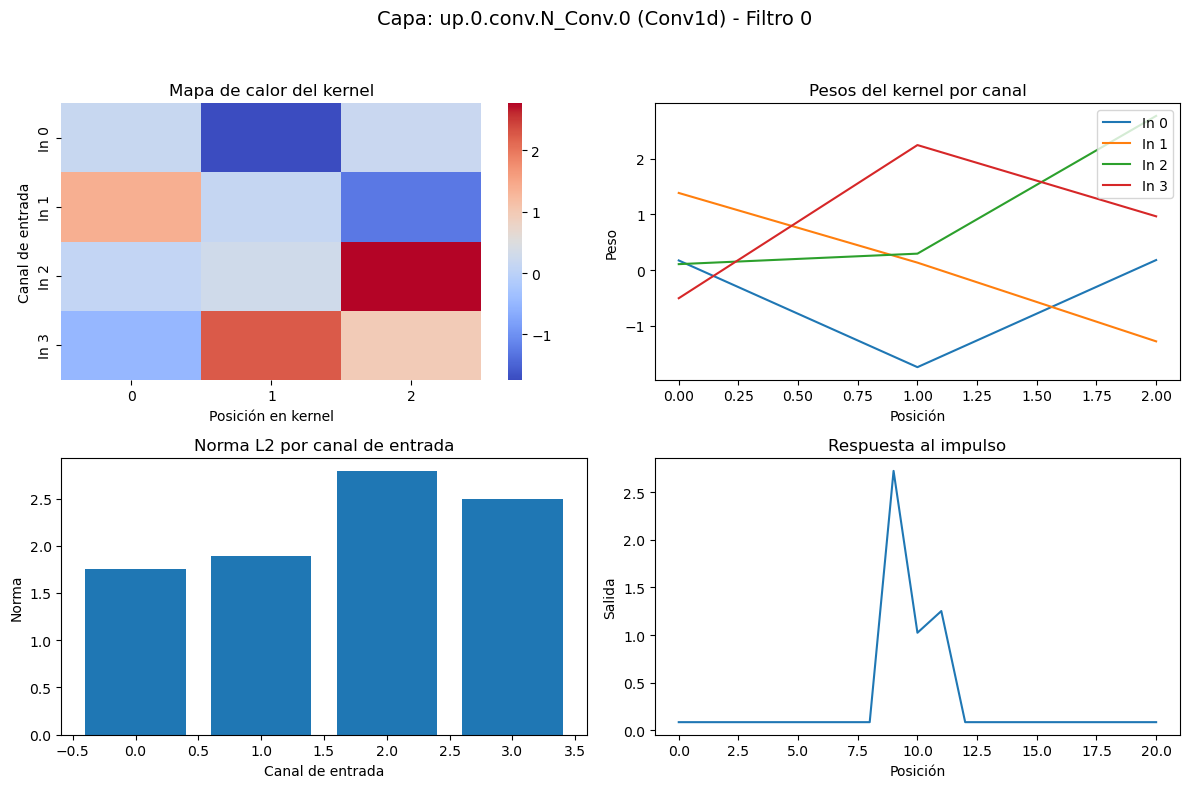

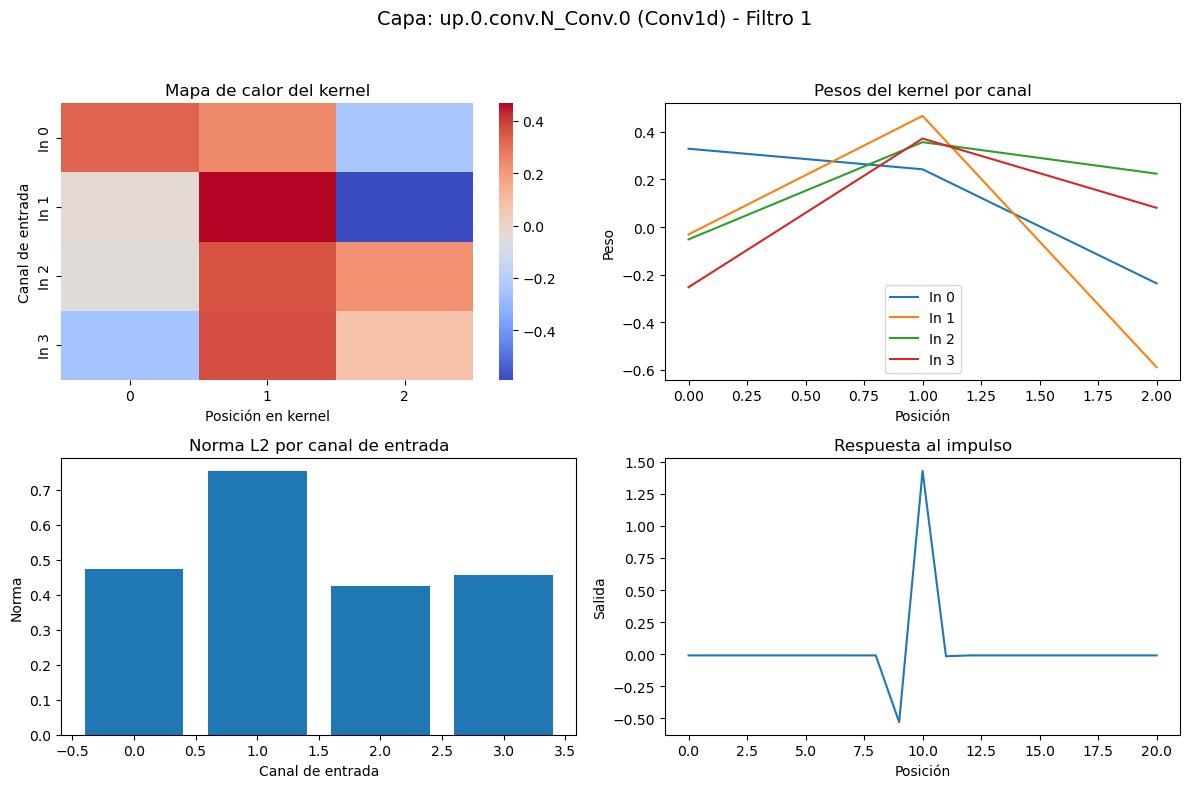

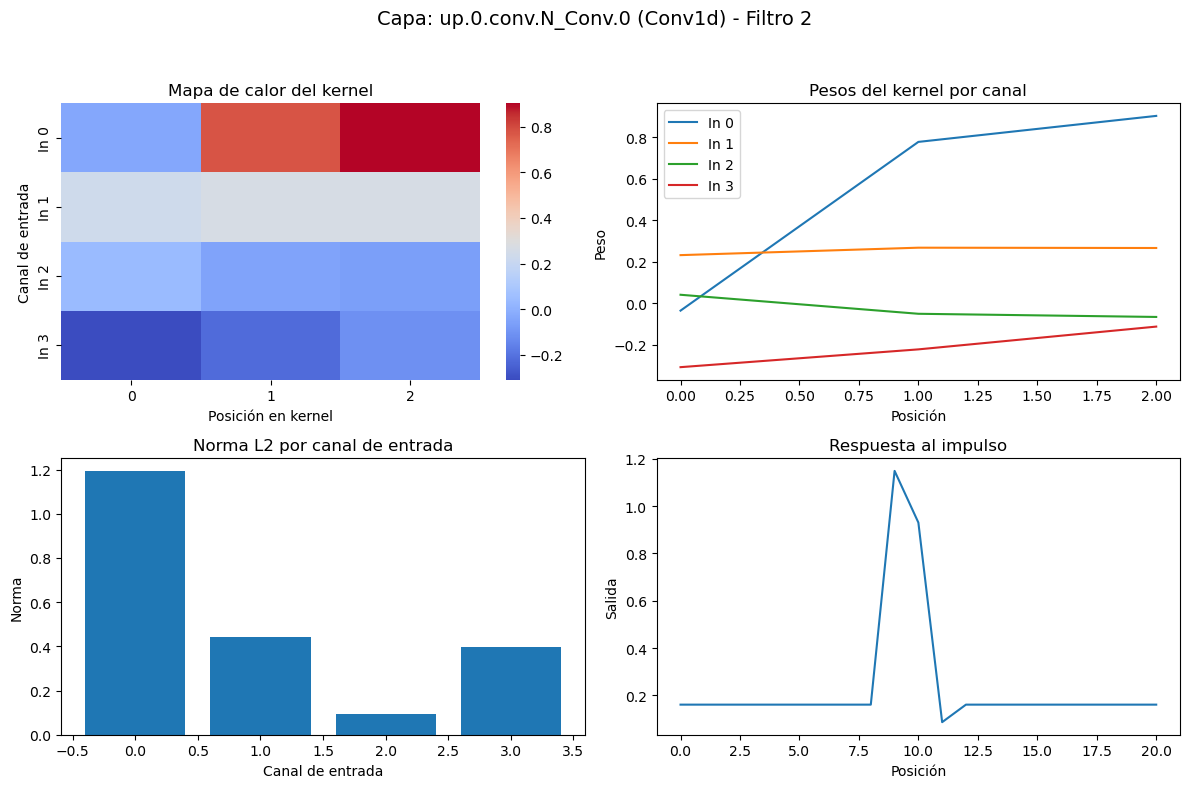

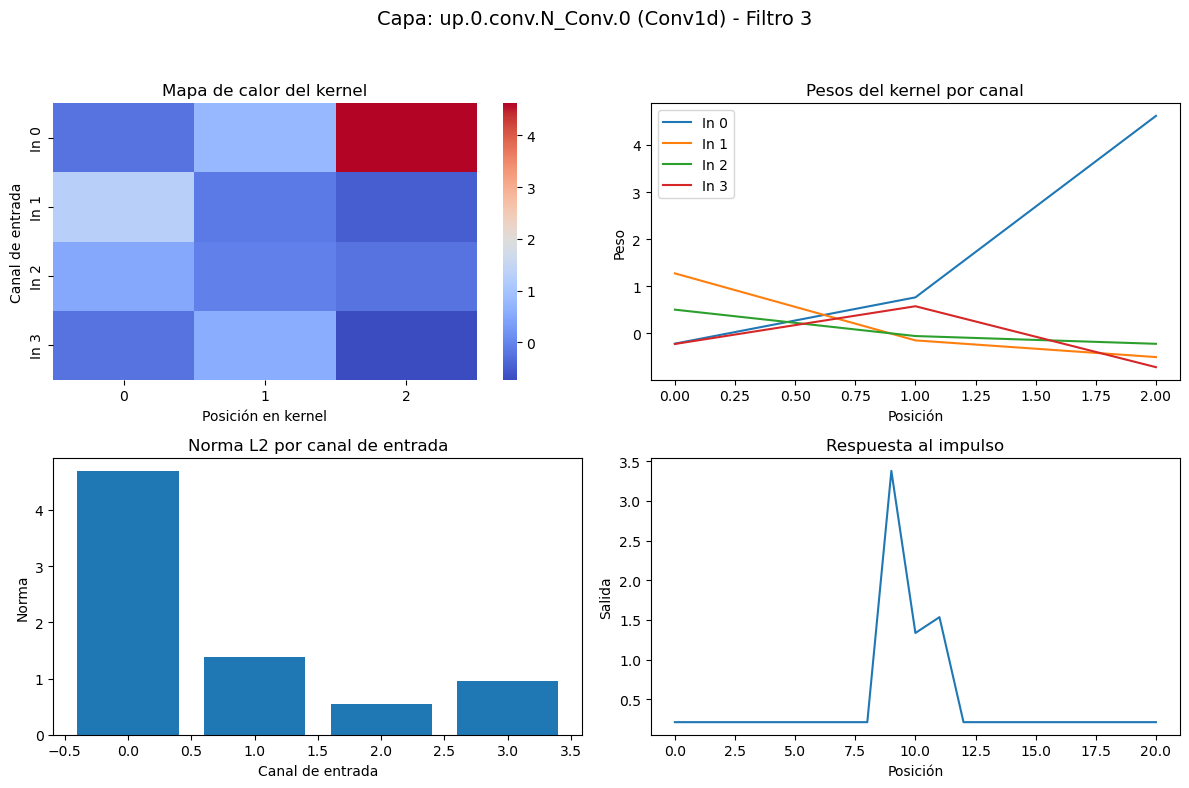

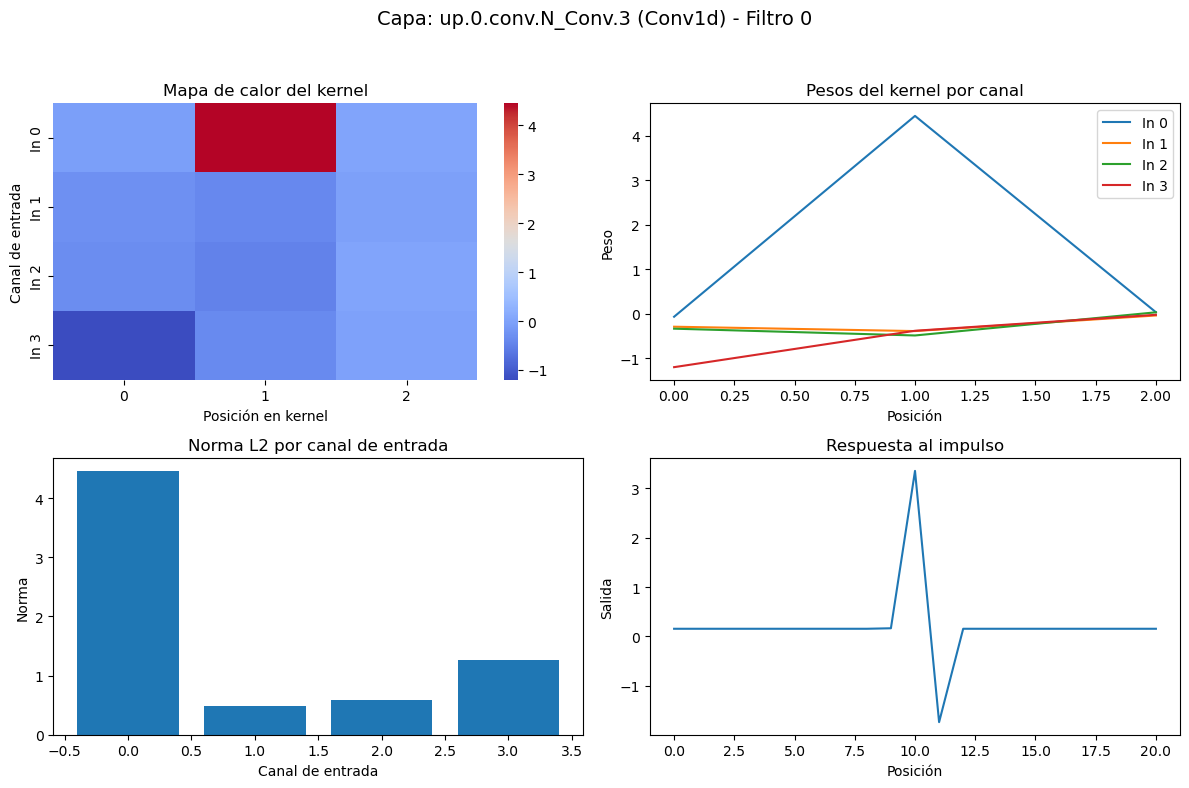

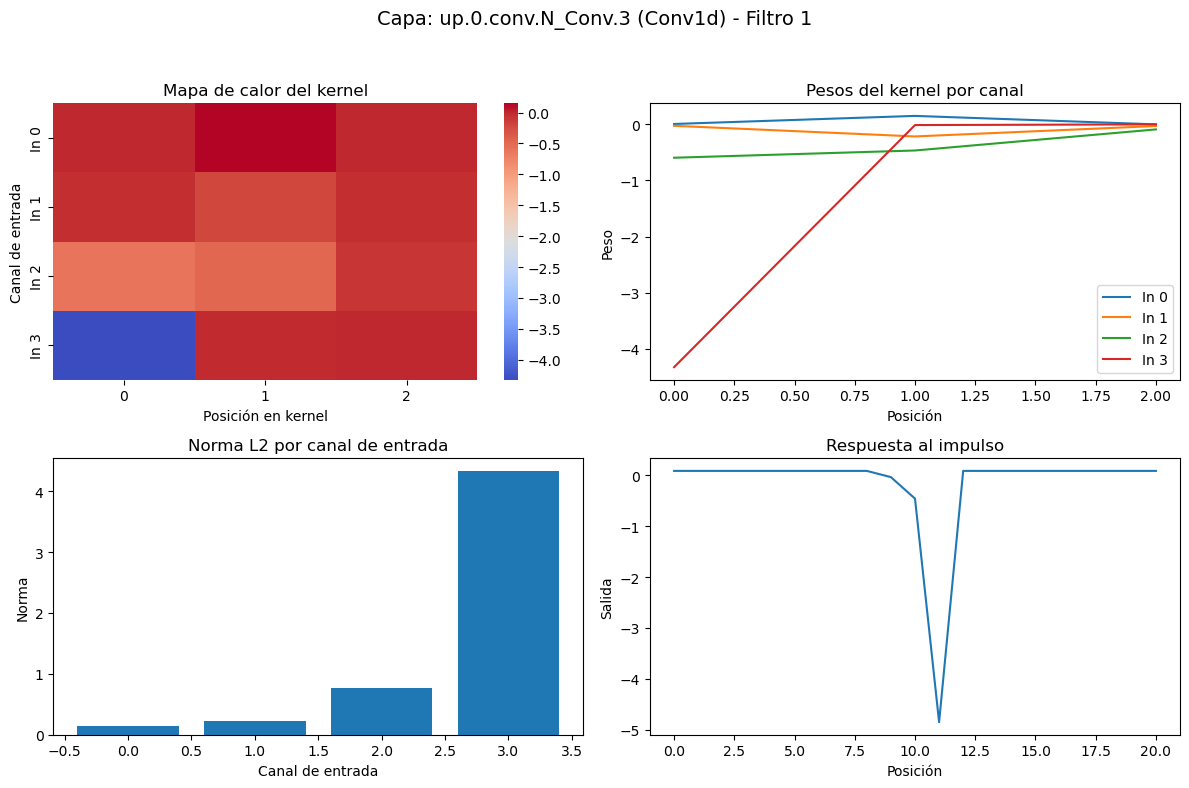

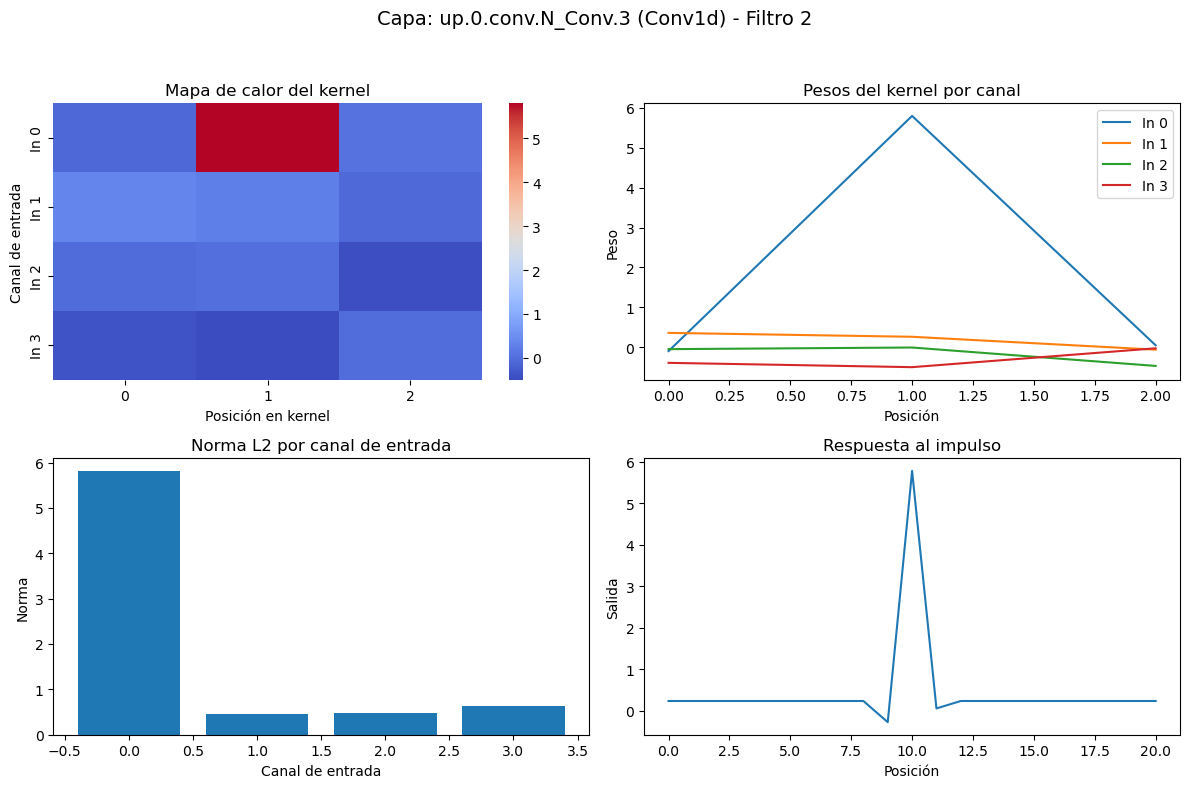

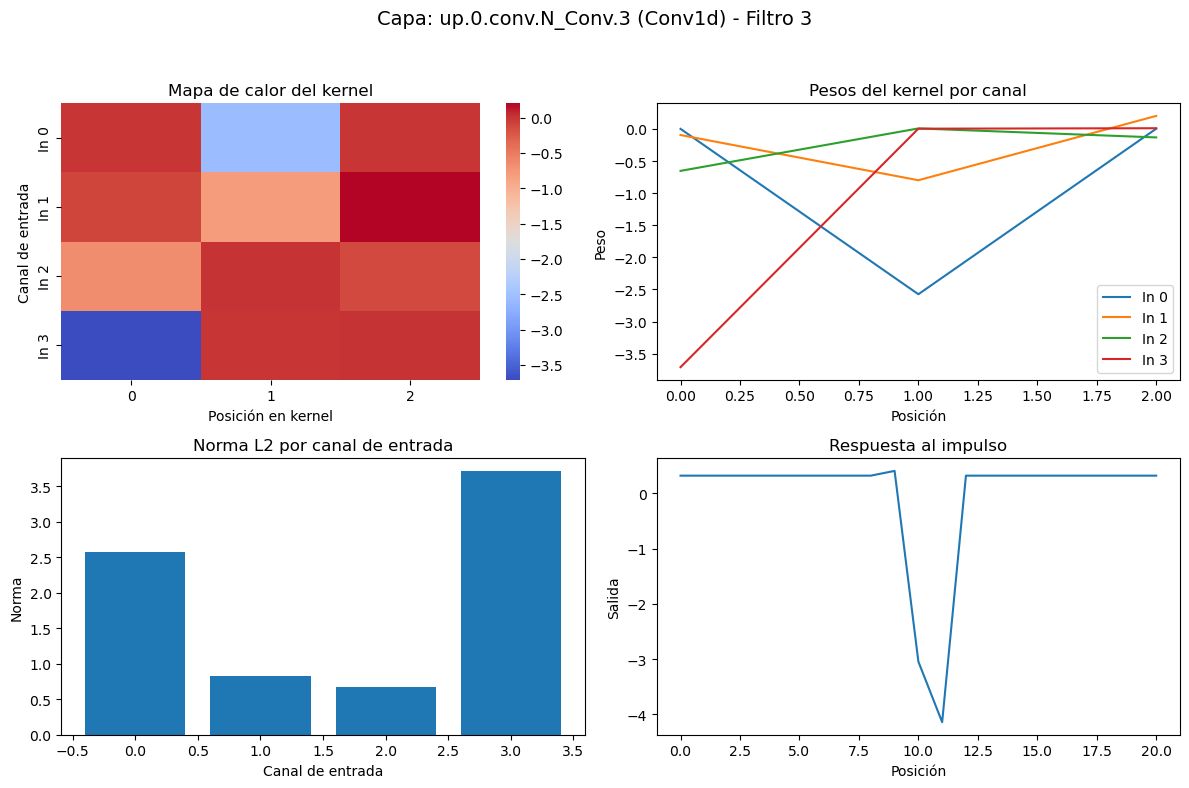

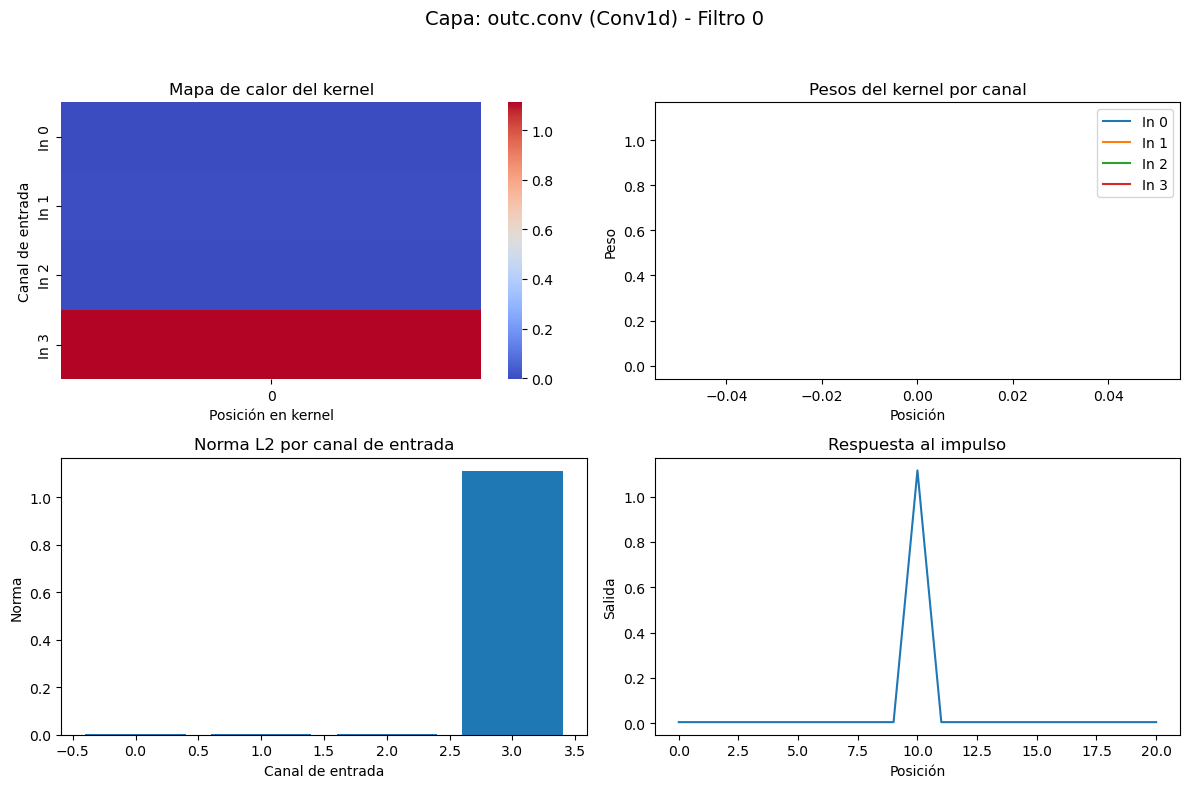

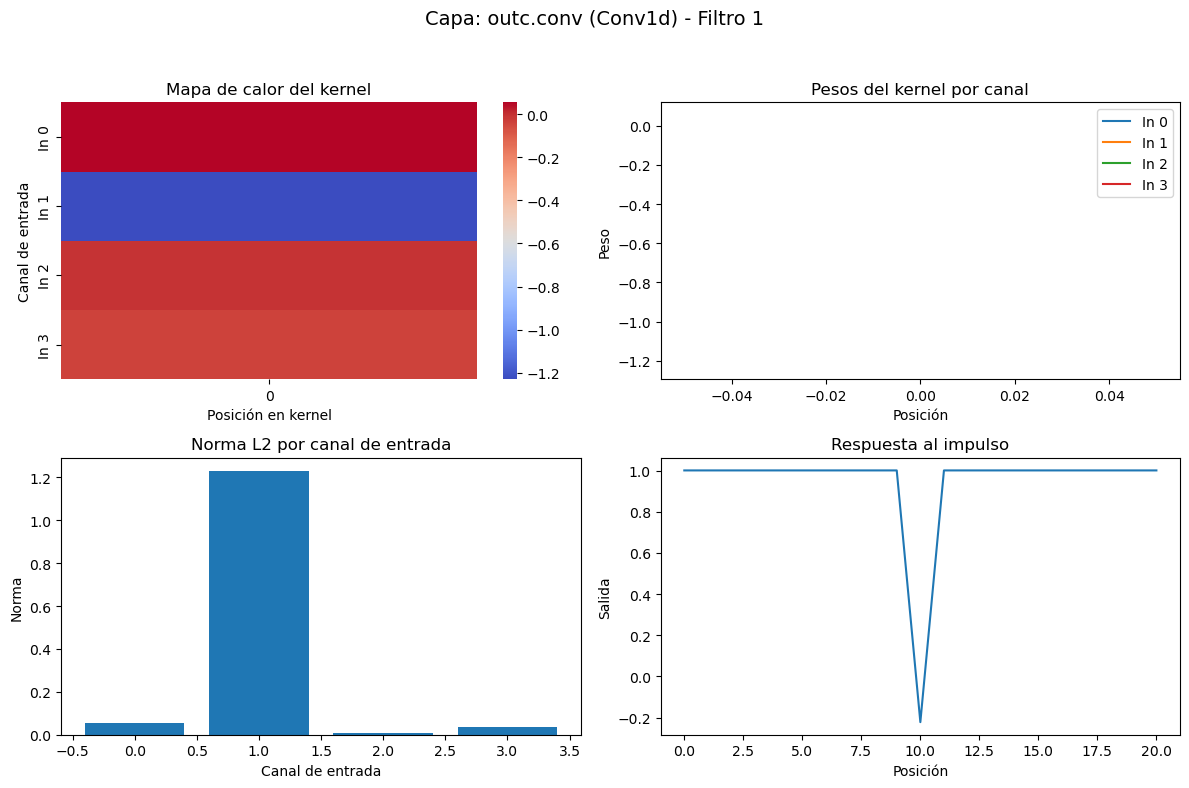

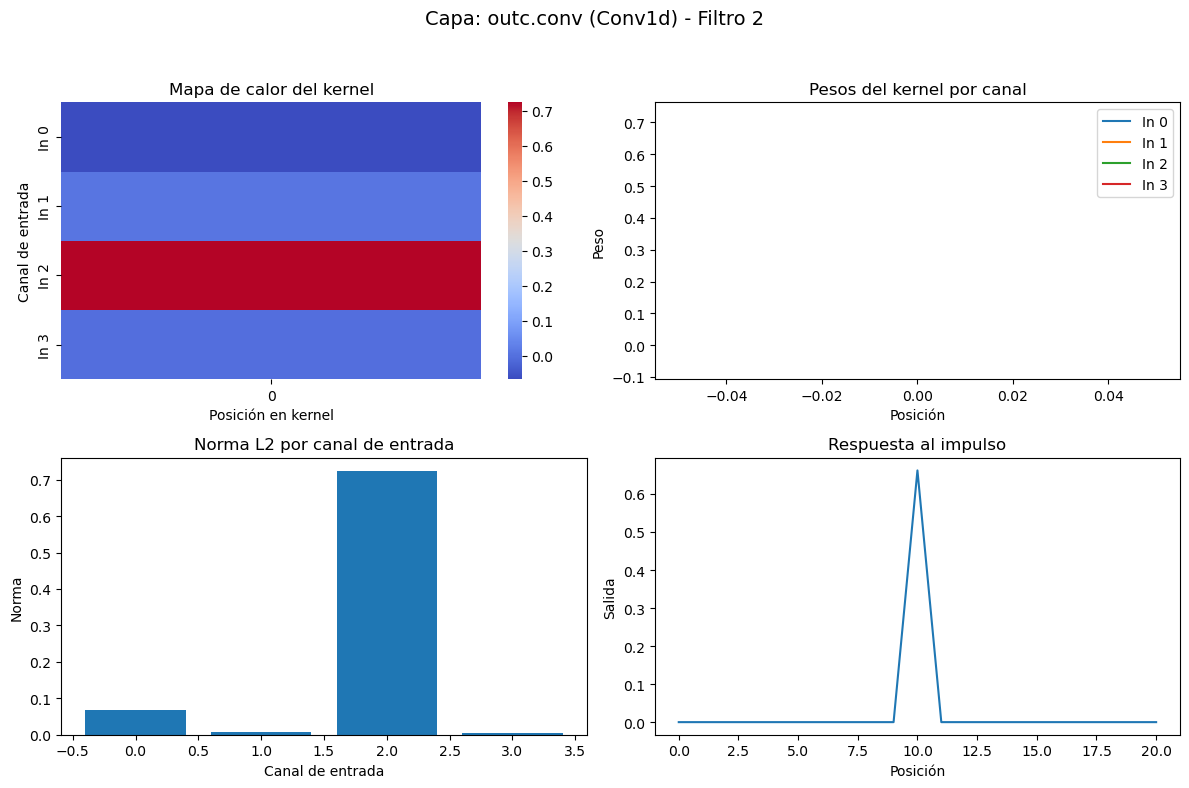

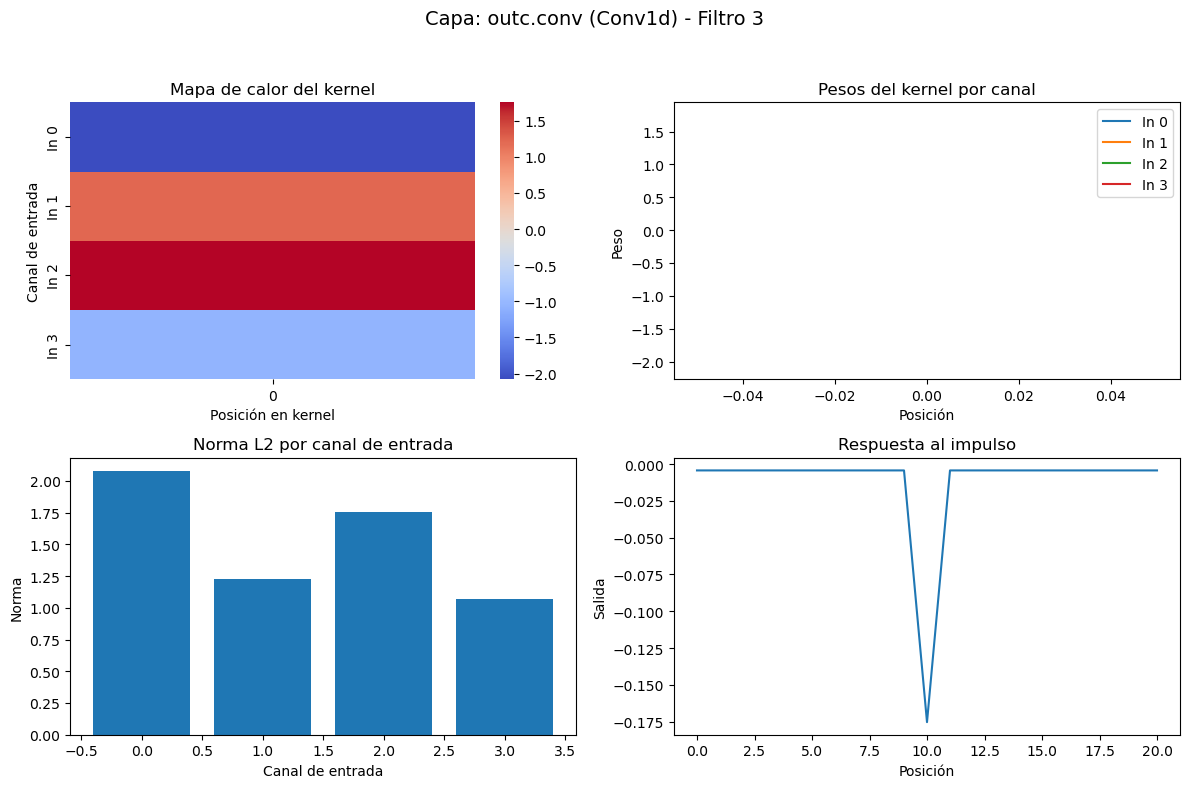

In [37]:
plot_full_kernel_analysis(model)
